Goal: predicting restocks value: <br>
1. Sales dataset and regression models (target variable 'restock')
2. Using restocks dataset and time series (target variable 'qty')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 25 16:17:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings
from scipy import stats
import scipy as scipy

# 1. Data Loading and Cleaning

- From https://github.com/HumaticsLAB/visuelle2.0-code/issues/6: The restock column in sales.csv corresponds to the total re-stocking products, including the initial stock (the first bench of products sent to stores). On the restock.csv file, you find the re-stocking information in detail.
The inventory series is computed by subtracting the item sells from the actual stock (last inventory + restock quantity).
- From https://github.com/HumaticsLAB/visuelle2.0-code/issues/10: (sales dataset) The values [0,1,...,11] represent the sales time series in the 12-week product lifecycle. The "external_code," on the other hand, is a product_id. Essentially, it serves to recognize a particular product uniquely

In [ ]:
sales = pd.read_csv("/content/drive/MyDrive/Visuelle/sales.csv")
sales.head()

,Unnamed: 0,external_code,retail,season,category,color,image_path,fabric,release_date,restock,...,2,3,4,5,6,7,8,9,10,11
0,0,5,36,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,22,...,1.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
1,1,2,51,SS17,long sleeve,violet,PE17/00002.png,acrylic,2016-11-28,17,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2,5,10,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,15,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
3,3,9,41,SS17,culottes,yellow,PE17/00009.png,scuba crepe,2016-11-28,32,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,4,5,13,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,26,...,4.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
sales.columns.values.tolist()

['Unnamed: 0',
 'external_code',
 'retail',
 'season',
 'category',
 'color',
 'image_path',
 'fabric',
 'release_date',
 'restock',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11']

In [ ]:
sales['retail'].unique()

array([ 36,  51,  10,  41,  13,   2,  22,  56,   3,  16,  19,  45,  24,
        47,  38,  49,  20,  43,   1,  18,  28,   6,  26,  46,   4,  63,
        40,   5,  39,  48,  59,  12,  57,   9,  62,   8,  30,   0,  37,
        61,  54,  32,  35,  27,  14,  65,  64,  42,  31,  60,  66,  21,
        52,  55,  58,  23,  50,  44,  25,  11,   7,  29,  33,  15,  17,
        53,  69,  72,  73,  68,  75,  82,  78,  84,  79,  77,  85,  86,
        90,  81,  80,  99, 100,  93,  83, 101,  76, 102,  95,  74, 110,
       104, 107, 109,  67, 117,  94,  89,  88,  92,  91,  96, 121, 103,
       115, 106, 125, 105, 108,  87])

In [ ]:
sales['external_code'].unique().shape

(5355,)

In [ ]:
restocks = pd.read_csv("/content/drive/MyDrive/Visuelle/restocks.csv")
restocks.head()

,external_code,retail,week,year,qty
0,3642,30,50,2018,5
1,3642,30,51,2018,6
2,3642,30,1,2019,2
3,3642,30,2,2019,3
4,3642,30,4,2019,4


In [ ]:
restocks['external_code'].unique().shape # sales has 5355 external_codes

(5346,)

In [ ]:
# Checking for missing values
restocks_missing = restocks.isnull().sum()
sales_missing = sales.isnull().sum()
print(restocks_missing, sales_missing)

external_code    0
retail           0
week             0
year             0
qty              0
dtype: int64 Unnamed: 0       0
external_code    0
retail           0
season           0
category         0
color            0
image_path       0
fabric           0
release_date     0
restock          0
0                0
1                0
2                0
3                0
4                0
5                0
6                0
7                0
8                0
9                0
10               0
11               0
dtype: int64


In [ ]:
restocks.head()

,external_code,retail,week,year,qty
0,3642,30,50,2018,5
1,3642,30,51,2018,6
2,3642,30,1,2019,2
3,3642,30,2,2019,3
4,3642,30,4,2019,4


In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106850 entries, 0 to 106849
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     106850 non-null  int64  
 1   external_code  106850 non-null  int64  
 2   retail         106850 non-null  int64  
 3   season         106850 non-null  object 
 4   category       106850 non-null  object 
 5   color          106850 non-null  object 
 6   image_path     106850 non-null  object 
 7   fabric         106850 non-null  object 
 8   release_date   106850 non-null  object 
 9   restock        106850 non-null  int64  
 10  0              106850 non-null  float64
 11  1              106850 non-null  float64
 12  2              106850 non-null  float64
 13  3              106850 non-null  float64
 14  4              106850 non-null  float64
 15  5              106850 non-null  float64
 16  6              106850 non-null  float64
 17  7              106850 non-nul

In [ ]:
sales_codes = set(sales['external_code'].unique())
restocks_codes = set(restocks['external_code'].unique())

# Find the differences
missing_in_restocks = sales_codes - restocks_codes
missing_in_sales_r = restocks_codes - sales_codes

print("External codes missing in restocks_data:")
print(missing_in_restocks)

print("\nExternal codes missing in sales:")
print(missing_in_sales_r)

External codes missing in restocks_data:
{2886, 3084, 4044, 4878, 3567, 4881, 4628, 981, 124}

External codes missing in sales:
set()


In [ ]:
# let's remove retail and aggregate data with the same external_code and release_date
sales_trimmed = sales.drop(columns=['Unnamed: 0', 'retail', 'season', 'category', 'color', 'image_path', 'fabric'])
sales_trimmed[sales_trimmed['external_code'] == 1]

,external_code,release_date,restock,0,1,2,3,4,5,6,7,8,9,10,11
130,1,2016-12-05,16,4.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
132,1,2016-12-05,21,2.0,2.0,3.0,0.0,2.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0
133,1,2016-12-05,20,3.0,3.0,1.0,4.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
136,1,2016-12-05,15,3.0,1.0,2.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
148,1,2016-12-05,10,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
176,1,2016-12-12,14,2.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sales[sales['external_code'] == 1]

,Unnamed: 0,external_code,retail,season,category,color,image_path,fabric,release_date,restock,...,2,3,4,5,6,7,8,9,10,11
130,130,1,20,SS17,long sleeve,violet,PE17/00001.png,acrylic,2016-12-05,16,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
132,132,1,24,SS17,long sleeve,violet,PE17/00001.png,acrylic,2016-12-05,21,...,3.0,0.0,2.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0
133,133,1,3,SS17,long sleeve,violet,PE17/00001.png,acrylic,2016-12-05,20,...,1.0,4.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
136,136,1,48,SS17,long sleeve,violet,PE17/00001.png,acrylic,2016-12-05,15,...,2.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
148,148,1,36,SS17,long sleeve,violet,PE17/00001.png,acrylic,2016-12-05,10,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
176,176,1,43,SS17,long sleeve,violet,PE17/00001.png,acrylic,2016-12-12,14,...,1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Aggregating sales data for items with the same external_code and release_date
aggregated_sales = sales_trimmed.groupby(['external_code', 'release_date']).sum().reset_index()
aggregated_sales.head()

,external_code,release_date,restock,0,1,2,3,4,5,6,7,8,9,10,11
0,1,2016-12-05,82,13.0,9.0,7.0,8.0,6.0,3.0,3.0,2.0,3.0,2.0,1.0,0.0
1,1,2016-12-12,14,2.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,2016-11-28,51,3.0,2.0,4.0,2.0,0.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0
3,2,2016-12-05,747,50.0,50.0,55.0,29.0,39.0,21.0,25.0,12.0,48.0,55.0,14.0,10.0
4,2,2016-12-12,129,13.0,4.0,7.0,3.0,10.0,5.0,4.0,7.0,10.0,4.0,4.0,3.0


In [ ]:
# aggregate dates per year, remove release_date and summarize values for same external_code and year
aggregated_sales['release_date'] = pd.to_datetime(aggregated_sales['release_date'], errors='coerce')
# Extract year from release_date
aggregated_sales['year'] = pd.to_datetime(aggregated_sales['release_date']).dt.year
aggregated_sales.head()

,external_code,release_date,restock,0,1,2,3,4,5,6,7,8,9,10,11,year
0,1,2016-12-05,82,13.0,9.0,7.0,8.0,6.0,3.0,3.0,2.0,3.0,2.0,1.0,0.0,2016
1,1,2016-12-12,14,2.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,2016
2,2,2016-11-28,51,3.0,2.0,4.0,2.0,0.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,2016
3,2,2016-12-05,747,50.0,50.0,55.0,29.0,39.0,21.0,25.0,12.0,48.0,55.0,14.0,10.0,2016
4,2,2016-12-12,129,13.0,4.0,7.0,3.0,10.0,5.0,4.0,7.0,10.0,4.0,4.0,3.0,2016


sales dataset contains sales data for each of the first 12 weeks following the release date (instead of just total sales), this provides a more granular view of how a product performs shortly after its release. Although this is still partial information compared to the weekly restocks data (which spans the entire year).<br> Strategy:
- Relative Week Alignment: For each product, align the first 12 weeks of sales data with the corresponding weeks in the restocks dataset based on the release date. This can allow you to see how initial sales performance correlates with restocking behavior.
- Match Sales with Corresponding Weeks: You could try to align sales week 1 with the first week of restocks after the product's release, and so on, even though the restocks dataset contains weekly data throughout the year.

In [ ]:
# Create a new DataFrame to hold the week number and sales data
sales_long = pd.melt(aggregated_sales, id_vars=['external_code', 'release_date', 'restock'],
                     value_vars=[str(i) for i in range(12)],
                     var_name='week', value_name='sales')

sales_long['week'] = sales_long['week'].astype(int)

# Calculate the actual week number based on the release date
sales_long['week_of_year'] = sales_long.apply(
    lambda row: (row['release_date'] + pd.DateOffset(weeks=row['week'])).isocalendar()[1], axis=1)

sales_long['year'] = sales_long['release_date'].dt.year

sales_long.head(25)

,external_code,release_date,restock,week,sales,week_of_year,year
0,1,2016-12-05,82,0,13.0,49,2016
1,1,2016-12-12,14,0,2.0,50,2016
2,2,2016-11-28,51,0,3.0,48,2016
3,2,2016-12-05,747,0,50.0,49,2016
4,2,2016-12-12,129,0,13.0,50,2016
5,2,2016-12-26,24,0,1.0,52,2016
6,3,2016-12-05,29,0,7.0,49,2016
7,4,2016-12-05,53,0,3.0,49,2016
8,4,2016-12-12,88,0,5.0,50,2016
9,4,2016-12-19,25,0,2.0,51,2016


In [ ]:
sales_long['week'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
sales_long['week_of_year'].unique()

array([49, 50, 48, 52, 51, 29, 28,  4,  2, 32, 25, 26, 30, 22, 20, 19, 11,
       27,  1,  3,  6,  7,  8,  9, 10,  5, 16, 23, 24, 12, 31, 13, 18, 21,
       14, 17, 15, 33, 34, 35, 36, 42, 37, 40, 47, 39, 45, 38, 44, 41, 43,
       46])

In [ ]:
# Find and display rows where both 'external_code' and 'week' are duplicated
duplicates = sales_long[sales_long.duplicated(subset=['external_code', 'release_date', 'week_of_year'], keep=False)]
duplicates.head()

,external_code,release_date,restock,week,sales,week_of_year,year


In [ ]:
aggregated_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   external_code  21742 non-null  int64         
 1   release_date   21742 non-null  datetime64[ns]
 2   restock        21742 non-null  int64         
 3   0              21742 non-null  float64       
 4   1              21742 non-null  float64       
 5   2              21742 non-null  float64       
 6   3              21742 non-null  float64       
 7   4              21742 non-null  float64       
 8   5              21742 non-null  float64       
 9   6              21742 non-null  float64       
 10  7              21742 non-null  float64       
 11  8              21742 non-null  float64       
 12  9              21742 non-null  float64       
 13  10             21742 non-null  float64       
 14  11             21742 non-null  float64       
 15  year           2174

In [ ]:
sales_long.head()

,external_code,release_date,restock,week,sales,week_of_year,year
0,1,2016-12-05,82,0,13.0,49,2016
1,1,2016-12-12,14,0,2.0,50,2016
2,2,2016-11-28,51,0,3.0,48,2016
3,2,2016-12-05,747,0,50.0,49,2016
4,2,2016-12-12,129,0,13.0,50,2016


In [ ]:
restocks.head()

,external_code,retail,week,year,qty
0,3642,30,50,2018,5
1,3642,30,51,2018,6
2,3642,30,1,2019,2
3,3642,30,2,2019,3
4,3642,30,4,2019,4


In [ ]:
restocks_cleaned = restocks.drop(columns=['retail'])

In [ ]:
restocks_cleaned = restocks_cleaned.groupby(['external_code', 'week', 'year']).agg({'qty': 'sum'}).reset_index()

In [ ]:
restocks_cleaned.head()

,external_code,week,year,qty
0,1,17,2017,5
1,1,48,2016,257
2,1,50,2016,82
3,1,51,2016,89
4,1,52,2016,63


In [ ]:
sales_long.head()

,external_code,release_date,restock,week,sales,week_of_year,year
0,1,2016-12-05,82,0,13.0,49,2016
1,1,2016-12-12,14,0,2.0,50,2016
2,2,2016-11-28,51,0,3.0,48,2016
3,2,2016-12-05,747,0,50.0,49,2016
4,2,2016-12-12,129,0,13.0,50,2016


In [ ]:
restocks_cleaned.to_csv('/content/drive/MyDrive/Visuelle/restocks_cleaned.csv', index=False)
sales_long.to_csv('/content/drive/MyDrive/Visuelle/sales_long.csv', index=False)

In [ ]:
# prep for the merge
# Remove the 'week' column from the sales_long dataset
sales_long = sales_long.drop(columns=['week'])

# Rename 'week_of_year' to 'week' in the sales_long dataset
sales_long = sales_long.rename(columns={'week_of_year': 'week'})

In [ ]:
# Perform the merge on external_code, year, and week
merged_data = pd.merge(sales_long, restocks_cleaned,
                       on=['external_code', 'year', 'week'],
                       how='inner')
merged_data.head()

,external_code,release_date,restock,sales,week,year,qty
0,1,2016-12-12,14,2.0,50,2016,82
1,1,2016-12-05,82,9.0,50,2016,82
2,2,2016-11-28,51,3.0,48,2016,257
3,2,2016-12-12,129,13.0,50,2016,166
4,2,2016-12-05,747,50.0,50,2016,166


In [ ]:
sales_long.shape

(260904, 6)

In [ ]:
restocks_cleaned.shape

(45352, 4)

In [ ]:
merged_data.shape

(99922, 7)

In [ ]:
merged_data.isnull().sum()

,0
external_code,0
release_date,0
restock,0
sales,0
week,0
year,0
qty,0


In [ ]:
# duplicates
merged_data[merged_data.duplicated()]

,external_code,release_date,restock,sales,week,year,qty


In [ ]:
# Verify that the merge was done correctly by checking for any unexpected anomalies, such as rows where sales data is present but restocks are not (or vice versa).
print(merged_data[(merged_data['sales'].isnull()) | (merged_data['qty'].isnull())])

Empty DataFrame
Columns: [external_code, release_date, restock, sales, week, year, qty]
Index: []


In [ ]:
merged_data.to_csv('/content/drive/MyDrive/Visuelle/merged_data.csv', index=False)

# 2. Exploratory Data Analysis (EDA)

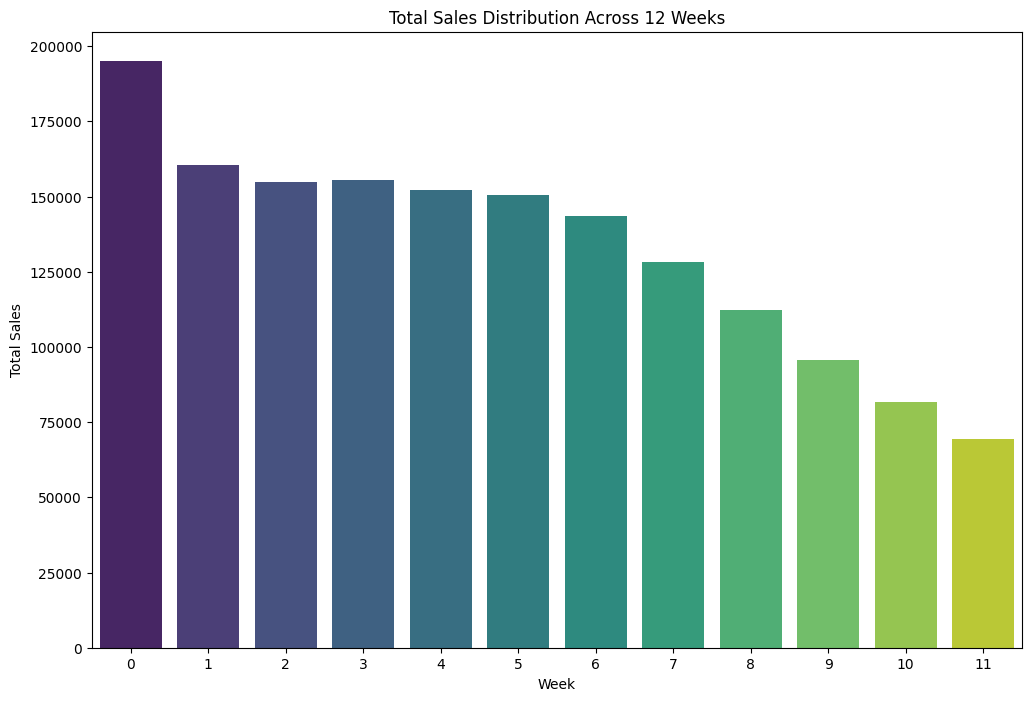

In [ ]:
# Sales Distribution Across Weeks
# can reveal important trends like peak sales periods or demand decline.

plt.figure(figsize=(12, 8))
sales_weeks = sales.loc[:, '0':'11'].sum()
sns.barplot(x=sales_weeks.index, y=sales_weeks.values, palette='viridis')
plt.title('Total Sales Distribution Across 12 Weeks')
plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.show()

The plot shows higher sales in the initial weeks with a gradual decline, typical in fast fashion due to trends.

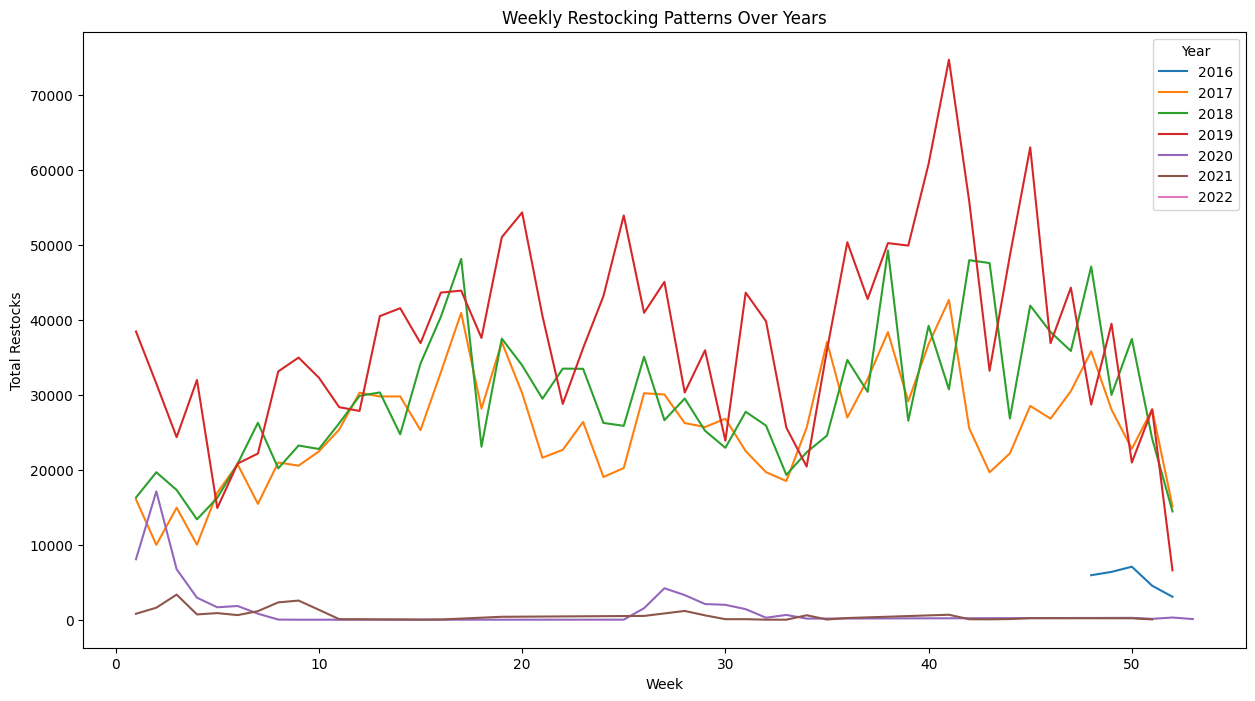

In [ ]:
# Restocking Patterns Over Time
# By plotting restocking quantities over different weeks and years,
# we can identify patterns such as seasonal effects or special promotional events
# that may influence restocking decisions.

restocks_weekly = restocks.groupby(['year', 'week'])['qty'].sum().reset_index()
plt.figure(figsize=(15, 8))
sns.lineplot(data=restocks_weekly, x='week', y='qty', hue='year', palette='tab10')
plt.title('Weekly Restocking Patterns Over Years')
plt.xlabel('Week')
plt.ylabel('Total Restocks')
plt.legend(title='Year')
plt.show()

The consistent pattern of restocks at certain times may align with seasonal demand spikes, indicating planned inventory strategies.

## Statistical Analysis

In [ ]:
# Descriptive Statistics
# Calculate descriptive statistics for numerical columns
sales.describe()

,Unnamed: 0,external_code,retail,release_date,restock,0,1,2,3,4,5,6,7,8,9,10,11
count,106850.000000,106850.000000,106850.000000,106850,106850.000000,106850.000000,106850.000000,106850.000000,106850.000000,106850.000000,106850.000000,106850.000000,106850.000000,106850.000000,106850.000000,106850.000000,106850.000000
mean,53424.500000,3108.302134,41.349415,2018-08-30 08:08:41.014506240,22.436022,1.825372,1.500440,1.448030,1.456359,1.423828,1.409911,1.343790,1.200468,1.050716,0.895133,0.763014,0.648779
min,0.000000,1.000000,0.000000,2016-11-28 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-3.000000,0.000000,0.000000,0.000000,-3.000000,-2.000000,0.000000
25%,26712.250000,1721.000000,18.000000,2017-11-27 00:00:00,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53424.500000,3173.000000,38.000000,2018-10-01 00:00:00,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,80136.750000,4592.750000,62.000000,2019-05-27 00:00:00,26.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000
max,106849.000000,5577.000000,125.000000,2019-12-30 00:00:00,389.000000,25.000000,27.000000,27.000000,27.000000,43.000000,34.000000,49.000000,36.000000,50.000000,45.000000,53.000000,43.000000
std,30845.082469,1593.085572,28.040672,NaN,16.970656,1.252241,1.564483,1.577184,1.643756,1.680707,1.758441,1.779213,1.692647,1.611809,1.549376,1.540595,1.432452


In [ ]:
restocks.describe()

,external_code,retail,week,year,qty
count,949766.000000,949766.000000,949766.000000,949766.000000,949766.000000
mean,3068.711310,43.261215,28.083644,2018.189321,5.204682
std,1616.280605,28.710344,14.602329,0.878331,3.832166
min,1.000000,0.000000,1.000000,2016.000000,1.000000
25%,1689.000000,19.000000,16.000000,2017.000000,2.000000
50%,3194.000000,41.000000,28.000000,2018.000000,5.000000
75%,4532.000000,64.000000,41.000000,2019.000000,7.000000
max,5577.000000,125.000000,53.000000,2022.000000,104.000000


In [ ]:
merged_data.describe()

,external_code,release_date,restock,sales,week,year,qty
count,99922.000000,99922,99922.000000,99922.000000,99922.000000,99922.000000,99922.000000
mean,2803.269040,2018-07-08 12:55:12.567802624,166.454324,10.650447,29.881678,2018.020306,110.194081
min,1.000000,2016-11-28 00:00:00,1.000000,-2.000000,1.000000,2016.000000,1.000000
25%,1411.000000,2017-09-25 00:00:00,23.000000,1.000000,18.000000,2017.000000,24.000000
50%,2642.000000,2018-06-18 00:00:00,56.000000,4.000000,28.000000,2018.000000,54.000000
75%,4329.000000,2019-05-13 00:00:00,151.000000,10.000000,43.000000,2019.000000,131.000000
max,5577.000000,2019-12-30 00:00:00,6288.000000,562.000000,52.000000,2019.000000,1574.000000
std,1642.125272,NaN,347.099591,21.799199,13.914966,0.833551,146.108841


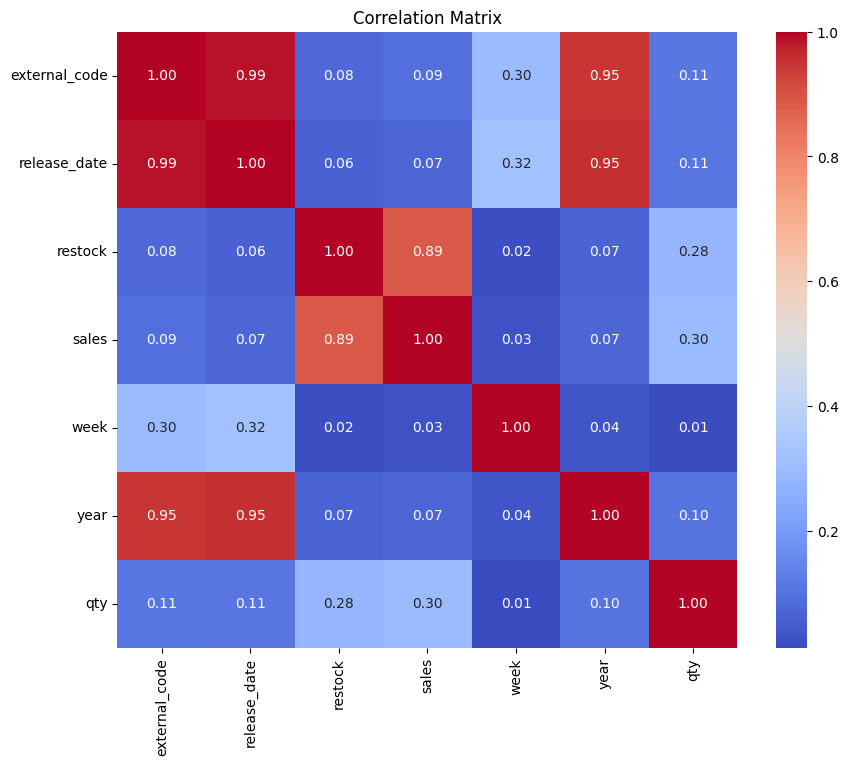

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = merged_data.corr()

# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# qty is not highly correlated, we might revert back to using sales dataset only and restock being the target variable. We can then use the restocks dataset to do a time series analysis.

**Using sales dataset for regression problem where target variable is restock**

Notes from previous statistic analysis: <br>
- The restock values range from 1 to 389, with a mean of approximately 22.4 and a standard deviation of around 17.0, indicating a right-skewed distribution with some outliers.
- The sales values (from weeks 0 to 11) have varying distributions, with average sales declining over the weeks. The maximum sales values in some weeks reach significantly high numbers, indicating potential outliers or high-demand products.

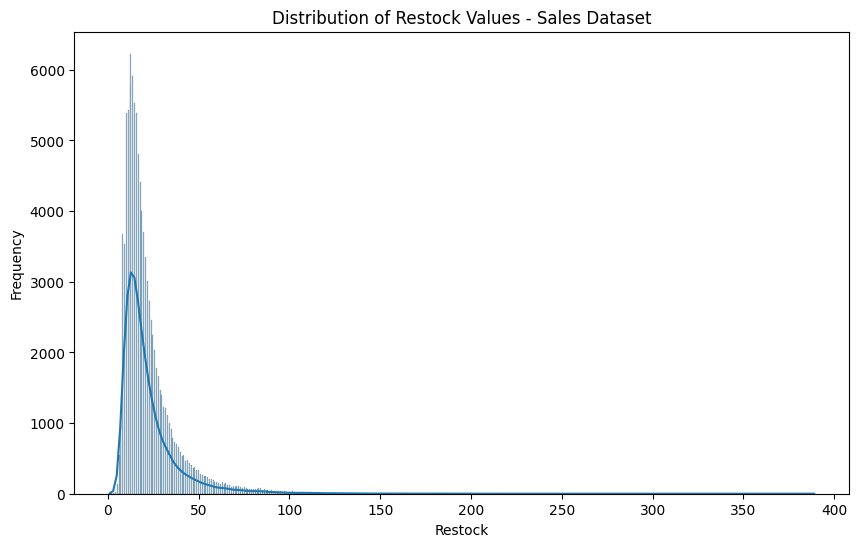

In [ ]:
# Distribution analysis of the restock variable
plt.figure(figsize=(10, 6))
sns.histplot(sales['restock'], kde=True)
plt.title('Distribution of Restock Values - Sales Dataset')
plt.xlabel('Restock')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Dropping unnecessary columns
sales_data = sales.drop(columns=['Unnamed: 0', 'image_path'])

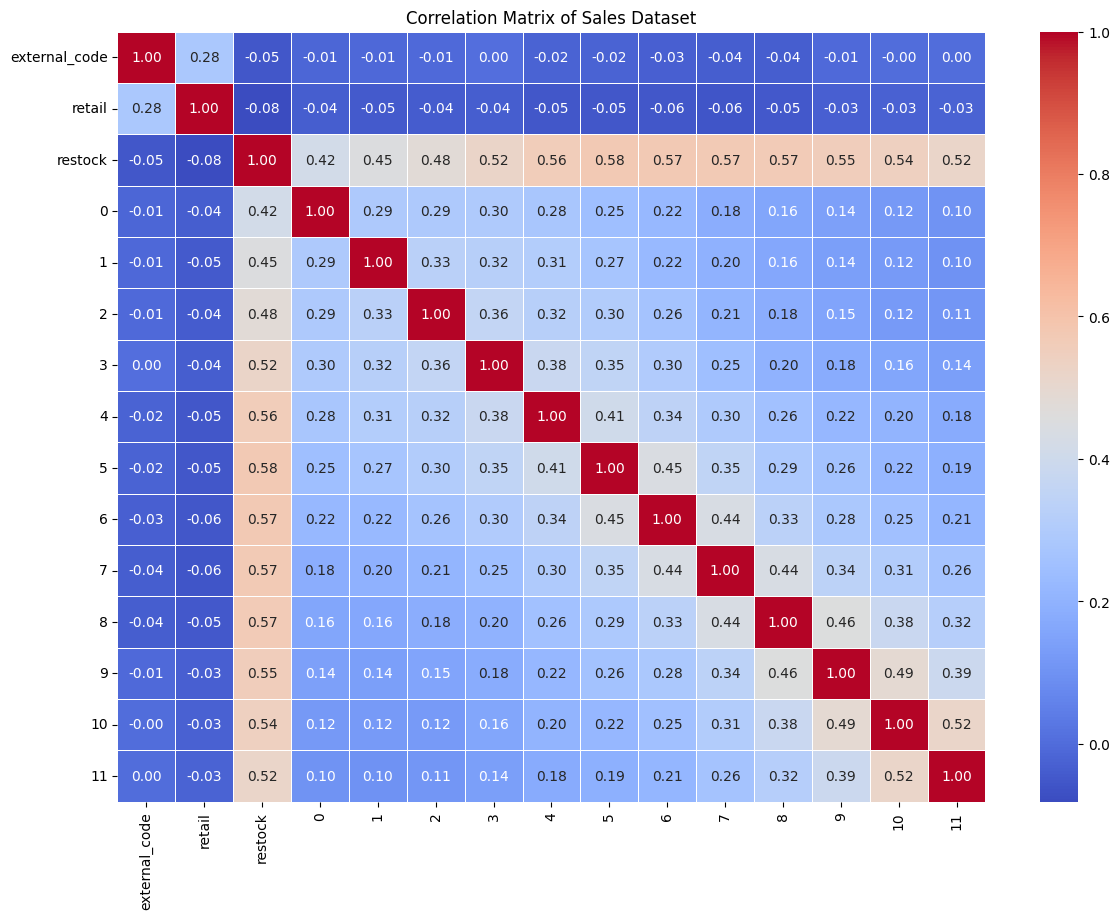

In [ ]:
# Correlation matrix to analyze relationships
correlation_matrix = sales_data.corr(numeric_only = True)

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Sales Dataset')
plt.show()

- The restock variable has some positive correlations with the early weeks' sales (weeks 0, 1, and 2), which makes sense since high initial sales might trigger more restocking.
- As the weeks progress, the correlation between weekly sales and restock decreases, likely due to the natural decline in sales over time.
- There are strong correlations between the sales in consecutive weeks, indicating a potential trend.

**Dealing with categorical value**

In [ ]:
# Encoding categorical variables, but want to avoid sparsity. Dropping fabric as it is connected to season & category.
sales_data = sales_data.drop(columns=['fabric'])

In [ ]:
# using one-hot encoding for categorical variables: 'season', 'category', 'color'
sales_data = pd.get_dummies(sales_data, columns=['season', 'category', 'color'], drop_first=True)

In [ ]:
sales_data.head()

,external_code,retail,release_date,restock,0,1,2,3,4,5,...,category_trapeze dress,color_blue,color_brown,color_green,color_grey,color_orange,color_red,color_violet,color_white,color_yellow
0,5,36,2016-11-28,22,1.0,3.0,1.0,1.0,2.0,1.0,...,False,False,False,False,True,False,False,False,False,False
1,2,51,2016-11-28,17,1.0,1.0,1.0,0.0,0.0,2.0,...,False,False,False,False,False,False,False,True,False,False
2,5,10,2016-11-28,15,1.0,3.0,1.0,0.0,1.0,1.0,...,False,False,False,False,True,False,False,False,False,False
3,9,41,2016-11-28,32,1.0,1.0,1.0,1.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
4,5,13,2016-11-28,26,1.0,2.0,4.0,0.0,3.0,0.0,...,False,False,False,False,True,False,False,False,False,False


In [ ]:
# Select columns that start with 'color', 'category', or 'season' to convert
columns_to_convert = sales_data.filter(regex='^(color|category|season)').columns

# Convert these selected columns to integers
sales_data[columns_to_convert] = sales_data[columns_to_convert].astype(int)

In [ ]:
sales_data.head()

,external_code,retail,release_date,restock,0,1,2,3,4,5,...,category_trapeze dress,color_blue,color_brown,color_green,color_grey,color_orange,color_red,color_violet,color_white,color_yellow
0,5,36,2016-11-28,22,1.0,3.0,1.0,1.0,2.0,1.0,...,0,0,0,0,1,0,0,0,0,0
1,2,51,2016-11-28,17,1.0,1.0,1.0,0.0,0.0,2.0,...,0,0,0,0,0,0,0,1,0,0
2,5,10,2016-11-28,15,1.0,3.0,1.0,0.0,1.0,1.0,...,0,0,0,0,1,0,0,0,0,0
3,9,41,2016-11-28,32,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,5,13,2016-11-28,26,1.0,2.0,4.0,0.0,3.0,0.0,...,0,0,0,0,1,0,0,0,0,0


One hot encoding preferred because avoid cardinality assumption (compared to Label Encoder)

# 3. Feature Engineering
Seasonality trend. Release date can't be used for the model so we create new features to capture potential seasonality patterns


In [ ]:
sales_data['release_date'] = pd.to_datetime(sales_data['release_date'])

# Create seasonality features
sales_data['is_winter_release'] = sales_data['release_date'].apply(lambda x: 1 if x.month in [12, 1, 2] else 0)
sales_data['is_summer_release'] = sales_data['release_date'].apply(lambda x: 1 if x.month in [6, 7, 8] else 0)
sales_data['is_autumn_release'] = sales_data['release_date'].apply(lambda x: 1 if x.month in [9, 10, 11] else 0)
sales_data['is_spring_release'] = sales_data['release_date'].apply(lambda x: 1 if x.month in [3, 4, 5] else 0)

# 4. Models Training
Linear Regression and Random Forest, are chosen to capture both linear and non-linear relationships.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [ ]:
sales_data.head()

,external_code,retail,release_date,restock,0,1,2,3,4,5,...,color_grey,color_orange,color_red,color_violet,color_white,color_yellow,is_winter_release,is_summer_release,is_autumn_release,is_spring_release
0,5,36,2016-11-28,22,1.0,3.0,1.0,1.0,2.0,1.0,...,1,0,0,0,0,0,0,0,1,0
1,2,51,2016-11-28,17,1.0,1.0,1.0,0.0,0.0,2.0,...,0,0,0,1,0,0,0,0,1,0
2,5,10,2016-11-28,15,1.0,3.0,1.0,0.0,1.0,1.0,...,1,0,0,0,0,0,0,0,1,0
3,9,41,2016-11-28,32,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0
4,5,13,2016-11-28,26,1.0,2.0,4.0,0.0,3.0,0.0,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
X = sales_data.drop(columns=['restock', 'release_date'])  # Drop non-feature columns
y = sales_data['restock']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Initialize the models
linear_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
# Train the models
linear_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
## linear was quick, random forest took time. (Data sparsity?)

In [ ]:
y_pred_linear = linear_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

In [ ]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, mape, rmse, r2

In [ ]:
print("Linear regression metrics:")
print(calculate_metrics(y_test, y_pred_linear))
print("Random Forest metrics:")
print(calculate_metrics(y_test, y_pred_rf))

Linear regression metrics:
(38.86770140363898, 4.183743767256526, 0.20768179656091418, 6.234396635091401, 0.8691354059804104)
Random Forest metrics:
(43.47016141943534, 4.363579160817345, 0.21712653607293972, 6.593190534137122, 0.853639273209302)


In [ ]:
# not much difference. Let's check linear dependence between target and indep variables

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting scatter plots for each feature against the target variable
for column in X.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=sales_data[column], y=sales_data['restock'])
    plt.title(f'Scatter plot of {column} vs Restock')
    plt.xlabel(column)
    plt.ylabel('Restock')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Trying additional models**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [ ]:
# Train Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Train SVM Regressor
svm_model = SVR()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Train ANN Regressor
ann_model = MLPRegressor(random_state=42)
ann_model.fit(X_train, y_train)
y_pred_ann = ann_model.predict(X_test)

In [ ]:
# Calculate metrics for each model
metrics = {}
metrics['Linear Regression'] = calculate_metrics(y_test, y_pred_linear)
metrics['Random Forest'] = calculate_metrics(y_test, y_pred_rf)
metrics['Decision Tree'] = calculate_metrics(y_test, y_pred_dt)
metrics['SVM'] = calculate_metrics(y_test, y_pred_svm)
metrics['ANN'] = calculate_metrics(y_test, y_pred_ann)

In [ ]:
# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics, index=['MSE', 'MAE', 'MAPE', 'RMSE', 'R2'])
metrics_df.head()

,Linear Regression,Random Forest,Decision Tree,SVM,ANN
MSE,38.867701,43.470161,108.552238,317.826817,41.672717
MAE,4.183744,4.363579,6.712089,9.884822,4.173142
MAPE,0.207682,0.217127,0.317187,0.414392,0.190749
RMSE,6.234397,6.593191,10.418841,17.827698,6.455441
R2,0.869135,0.853639,0.634513,-0.070099,0.859691


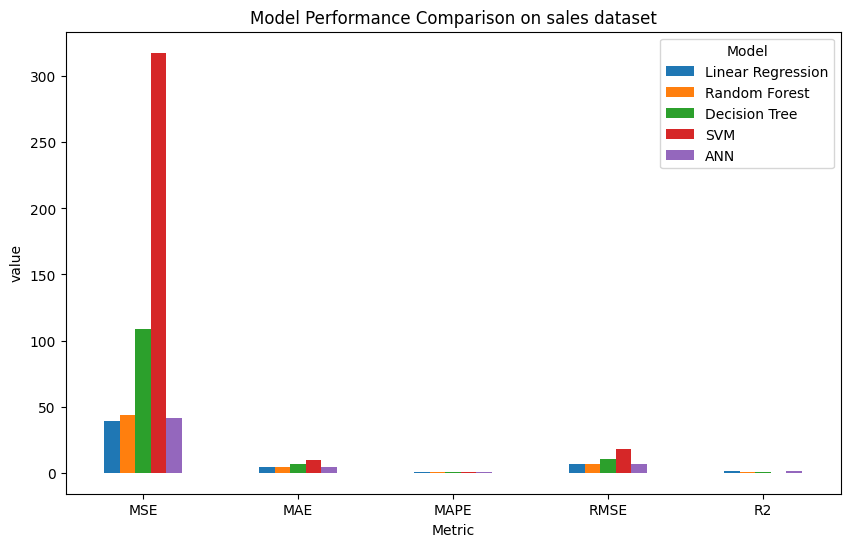

In [ ]:
# Plot the metrics
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison on sales dataset')
plt.xlabel('Metric')
plt.ylabel('value')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.show()

**Observations**:
- MSE (Mean Squared Error):

The SVM model has the highest MSE, indicating it performed the worst among all models.
Random Forest and Decision Tree models also show higher MSE compared to Linear Regression and ANN.
The Linear Regression and ANN models have relatively lower MSEs, suggesting better performance compared to the other models.
- MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error):

These metrics show a similar trend to MSE, with the SVM model performing the worst.
The Linear Regression and ANN models have the lowest MAE and RMSE, indicating that their predictions are closer to the actual values on average.
- MAPE (Mean Absolute Percentage Error):

MAPE values seem to be very low for all models, which could be a sign of very small actual values in the target variable. However, due to skewness in the data, MAPE may not be a reliable metric in this case.
- R² (Coefficient of Determination):

R² values across models appear very low or negative, indicating that none of the models fit the data well. This aligns with the data being sparse and lacking linear dependency between the target and independent variables.
The negative R² value for some models (such as SVM) indicates that these models perform worse than a simple mean prediction.
- *Best performing:* Linear Regression and ANN both show the best performance across almost all metrics. Given the data characteristics (sparsity, lack of linear dependency, skewed target distribution), it’s interesting that Linear Regression performed so well, possibly due to its simplicity and robustness to overfitting.

<br>**Comments based on Data Characteristics:**

- Sparsity: Sparse data often causes challenges for models, especially if there are few observations relative to the number of features. This could explain why complex models like Random Forest, Decision Tree, and SVM did not perform well.

- No Linear Dependency: Since there's no linear dependency, models like Linear Regression may not be appropriate, though it performed relatively better, possibly due to overfitting to certain patterns in the training data.

- Non-Normal or Unscaled Data: Non-normal and unscaled data can impact model performance, particularly for models like SVM and ANN, which are sensitive to feature scaling and data distribution. Feature scaling (normalization or standardization) could improve the performance of these models.

- Skewed Target Variable: A skewed distribution of the target variable can cause models to perform poorly, especially if they are not robust to such distributional characteristics. Transforming the target variable (e.g., log transformation) might improve model performance.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Refit all models with the standardized dataset
# Linear Regression
linear_model.fit(X_train_scaled, y_train)
y_pred_lr = linear_model.predict(X_test_scaled)

# Random Forest
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Decision Tree
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)

# SVM
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

# ANN
ann_model.fit(X_train_scaled, y_train)
y_pred_ann = ann_model.predict(X_test_scaled)

In [ ]:
# Evaluate models again
metrics = {
    'Linear Regression': calculate_metrics(y_test, y_pred_lr),
    'Random Forest': calculate_metrics(y_test, y_pred_rf),
    'Decision Tree': calculate_metrics(y_test, y_pred_dt),
    'SVM': calculate_metrics(y_test, y_pred_svm),
    'ANN': calculate_metrics(y_test, y_pred_ann),
}

# Convert metrics to DataFrame
metrics_df_scaled = pd.DataFrame(metrics, index=['MSE', 'MAE', 'MAPE', 'RMSE', 'R2'])
metrics_df_scaled.head()

,Linear Regression,Random Forest,Decision Tree,SVM,ANN
MSE,38.867808,43.350299,108.094587,86.775467,30.763979
MAE,4.183771,4.365151,6.710030,4.361908,3.806253
MAPE,0.207684,0.217327,0.317455,0.186804,0.190989
RMSE,6.234405,6.584094,10.396855,9.315335,5.546529
R2,0.869135,0.854043,0.636054,0.707834,0.896420


In [ ]:
metrics_df.head()

,Linear Regression,Random Forest,Decision Tree,SVM,ANN
MSE,38.867701,43.470161,108.552238,317.826817,41.672717
MAE,4.183744,4.363579,6.712089,9.884822,4.173142
MAPE,0.207682,0.217127,0.317187,0.414392,0.190749
RMSE,6.234397,6.593191,10.418841,17.827698,6.455441
R2,0.869135,0.853639,0.634513,-0.070099,0.859691


In [ ]:
metrics_df_scaled.head()

,Linear Regression,Random Forest,Decision Tree,SVM,ANN
MSE,38.867808,43.350299,108.094587,86.775467,30.763979
MAE,4.183771,4.365151,6.710030,4.361908,3.806253
MAPE,0.207684,0.217327,0.317455,0.186804,0.190989
RMSE,6.234405,6.584094,10.396855,9.315335,5.546529
R2,0.869135,0.854043,0.636054,0.707834,0.896420


In [ ]:
# Import
#metrics_df = pd.read_csv('/content/drive/MyDrive/Visuelle/metrics_original.csv', index_col=0)
#metrics_df_scaled = pd.read_csv('/content/drive/MyDrive/Visuelle/metrics_scaled.csv', index_col=0)

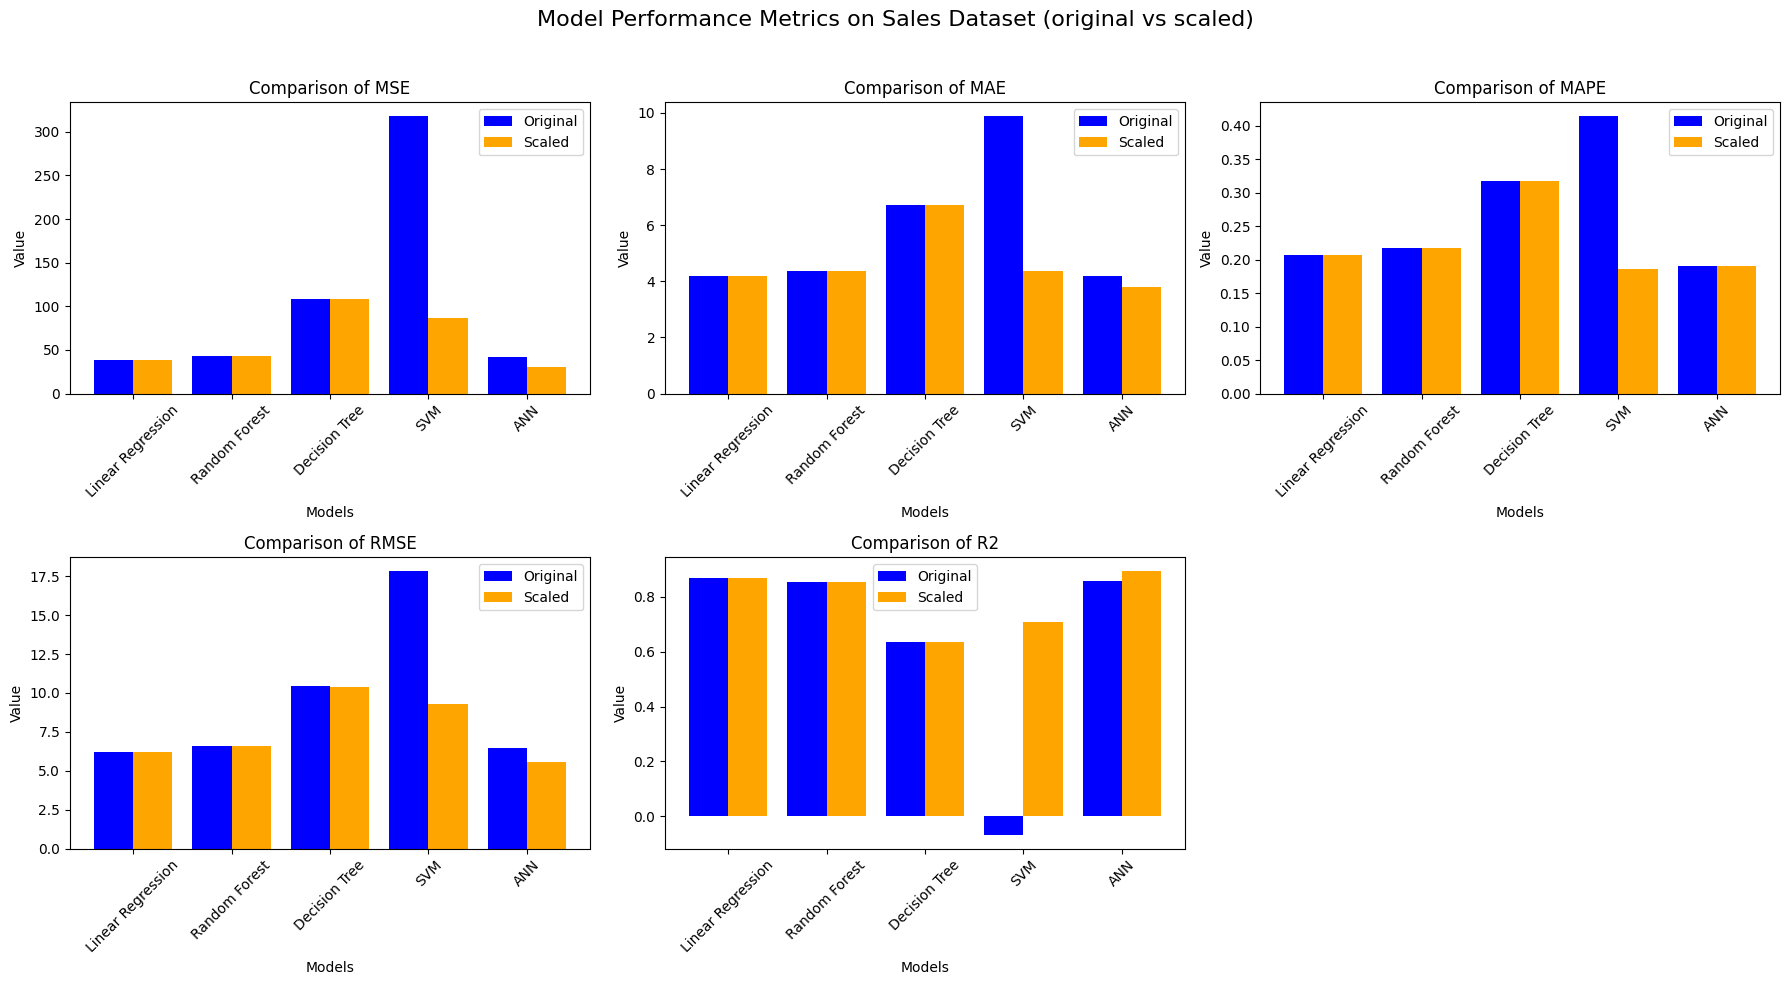

In [ ]:
# Add a 'Dataset' column to distinguish between original and scaled
metrics_df['Dataset'] = 'Original'
metrics_df_scaled['Dataset'] = 'Scaled'

combined_df = pd.concat([metrics_df, metrics_df_scaled], ignore_index=False)

# Melt the combined DataFrame to a long format for plotting
combined_melted = combined_df.reset_index().melt(id_vars=['index', 'Dataset'], var_name='Model', value_name='Score')

# Rename 'index' column to 'Metric' to reflect its content
combined_melted.rename(columns={'index': 'Metric'}, inplace=True)

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=False)

# List of metrics for iteration
metrics = combined_melted['Metric'].unique()
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for the current metric
    metric_data = combined_melted[combined_melted['Metric'] == metric]

    # Skip plot if there's no data
    if metric_data.empty:
        ax.axis('off')  # Turn off the axis if there's no data
        continue

    bar_width = 0.4
    x = range(len(metric_data[metric_data['Dataset'] == 'Original']))

    original_scores = metric_data[metric_data['Dataset'] == 'Original']
    scaled_scores = metric_data[metric_data['Dataset'] == 'Scaled']

    # Create bars for original (blue) and scaled (orange)
    ax.bar(x, original_scores['Score'], width=bar_width, color='blue', label='Original')
    ax.bar([pos + bar_width for pos in x], scaled_scores['Score'], width=bar_width, color='orange', label='Scaled')

    ax.set_title(f'Comparison of {metric}')
    ax.set_xlabel('Models')
    ax.set_ylabel('Value')
    ax.set_xticks([pos + bar_width / 2 for pos in x])
    ax.set_xticklabels(original_scores['Model'], rotation=45)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Model Performance Metrics on Sales Dataset (original vs scaled)', fontsize=16)

# Adjust layout to make space for the suptitle
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect parameter to make space for the title
plt.show()

Scaling definitely improves and so far the two candidates models are SVM and ANN. Next step, let's apply a transformation to the skewed target variable, such as a logarithmic transformation, as it can often improve model performance, especially for models like Linear Regression and Artificial Neural Networks (ANN) that assume normally distributed residuals.

In [ ]:
# X_train_scaled, X_test_scaled, and y are already defined

# Apply logarithmic transformation to the target variable
y_log = np.log(y)

# only y_log is split
_, _, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.3, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'SVM': SVR(),
    'ANN': MLPRegressor(random_state=42)
}

metrics = {'Model': [], 'MSE': [], 'MAE': [], 'MAPE': [], 'RMSE': [], 'R2': []}


In [ ]:
# Fit and evaluate models on scaled features and log-transformed target variable
for name, model in models.items():
    model.fit(X_train_scaled, y_train_log)
    y_pred_log = model.predict(X_test_scaled)

    # Inverse transform the predictions
    y_pred = np.exp(y_pred_log)
    y_test = np.exp(y_test_log)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    metrics['Model'].append(name)
    metrics['MSE'].append(mse)
    metrics['MAE'].append(mae)
    metrics['MAPE'].append(mape)
    metrics['RMSE'].append(rmse)
    metrics['R2'].append(r2)

In [ ]:
print(metrics)

{'Model': ['Linear Regression', 'Random Forest', 'Decision Tree', 'SVM', 'ANN'], 'MSE': [169644.14749006758, 48.21014585164009, 109.27783497114332, 47.93109432538529, 84.40138758072518], 'MAE': [11.726856099043825, 4.366333944848614, 6.76465450007799, 3.8130994584331126, 3.953842055373963], 'MAPE': [0.2674465993999522, 0.20401143044789027, 0.31922604326554205, 0.17457931283041886, 0.17784934044856388], 'RMSE': [411.8788019430808, 6.943352637713289, 10.453603922626078, 6.923228605599073, 9.187022781114957], 'R2': [-570.1789400288174, 0.837680106189418, 0.632069842249547, 0.8386196514512961, 0.7158269482998667]}


In [ ]:
# Convert results to DataFrame
metrics_df_log_transformed_scaled = pd.DataFrame(metrics)
metrics_df_log_transformed_scaled.head()

,Model,MSE,MAE,MAPE,RMSE,R2
0,Linear Regression,169644.147490,11.726856,0.267447,411.878802,-570.178940
1,Random Forest,48.210146,4.366334,0.204011,6.943353,0.837680
2,Decision Tree,109.277835,6.764655,0.319226,10.453604,0.632070
3,SVM,47.931094,3.813099,0.174579,6.923229,0.838620
4,ANN,84.401388,3.953842,0.177849,9.187023,0.715827


In [ ]:
metrics_df.head()

,Linear Regression,Random Forest,Decision Tree,SVM,ANN,Dataset
MSE,38.867701,43.470161,108.552238,317.826817,41.672717,Original
MAE,4.183744,4.363579,6.712089,9.884822,4.173142,Original
MAPE,0.207682,0.217127,0.317187,0.414392,0.190749,Original
RMSE,6.234397,6.593191,10.418841,17.827698,6.455441,Original
R2,0.869135,0.853639,0.634513,-0.070099,0.859691,Original


In [ ]:
# Transpose the DataFrame so that models become columns and metrics become the index
metrics_df_log_transformed_scaled_pivot = metrics_df_log_transformed_scaled.set_index('Model').T

# Add the 'Dataset' column to match other DataFrames
metrics_df_log_transformed_scaled_pivot['Dataset'] = 'Log-Transformed Scaled'
metrics_df_log_transformed_scaled = metrics_df_log_transformed_scaled_pivot

metrics_df_log_transformed_scaled.head()

Model,Linear Regression,Random Forest,Decision Tree,SVM,ANN,Dataset
MSE,169644.147490,48.210146,109.277835,47.931094,84.401388,Log-Transformed Scaled
MAE,11.726856,4.366334,6.764655,3.813099,3.953842,Log-Transformed Scaled
MAPE,0.267447,0.204011,0.319226,0.174579,0.177849,Log-Transformed Scaled
RMSE,411.878802,6.943353,10.453604,6.923229,9.187023,Log-Transformed Scaled
R2,-570.178940,0.837680,0.632070,0.838620,0.715827,Log-Transformed Scaled


In [ ]:

metrics_df.to_csv('/content/drive/MyDrive/Visuelle/metrics_original.csv', index=True)
metrics_df_scaled.to_csv('/content/drive/MyDrive/Visuelle/metrics_scaled.csv', index=True)
metrics_df_log_transformed_scaled_pivot.to_csv('/content/drive/MyDrive/Visuelle/metrics_log_transformed_scaled.csv', index=True)

In [ ]:
# metrics_df_log_transformed_scaled = pd.read_csv('/content/drive/MyDrive/Visuelle/metrics_log_transformed_scaled.csv', index_col=0)

In [ ]:
metrics_df_scaled.head()

,Linear Regression,Random Forest,Decision Tree,SVM,ANN,Dataset
MSE,38.867808,43.350299,108.094587,86.775467,30.763979,Scaled
MAE,4.183771,4.365151,6.710030,4.361908,3.806253,Scaled
MAPE,0.207684,0.217327,0.317455,0.186804,0.190989,Scaled
RMSE,6.234405,6.584094,10.396855,9.315335,5.546529,Scaled
R2,0.869135,0.854043,0.636054,0.707834,0.896420,Scaled


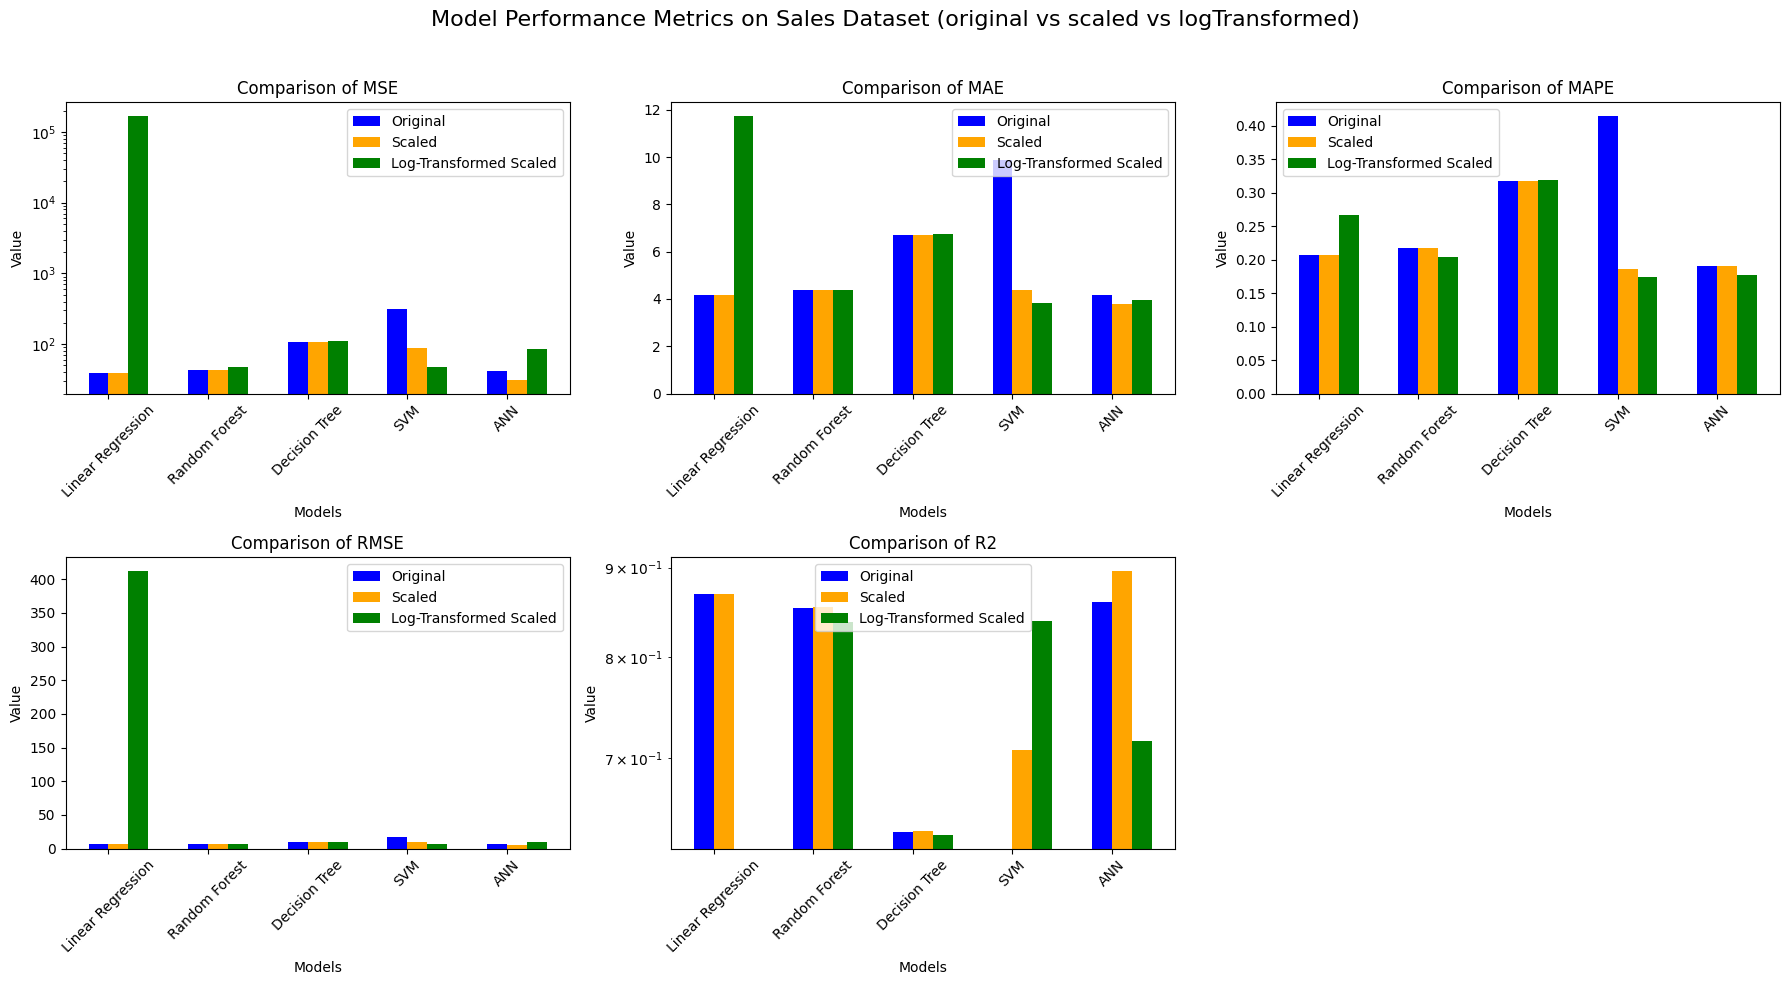

In [ ]:
metrics_df_log_transformed_scaled['Dataset'] = 'Log-Transformed Scaled'

# Combine all DataFrames
combined_df = pd.concat([metrics_df, metrics_df_scaled, metrics_df_log_transformed_scaled], ignore_index=False)

# Melt the combined DataFrame to a long format for plotting
combined_melted = combined_df.reset_index().melt(id_vars=['index', 'Dataset'], var_name='Model', value_name='Score')

combined_melted.rename(columns={'index': 'Metric'}, inplace=True)

combined_melted['Score'] = pd.to_numeric(combined_melted['Score'], errors='coerce')

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=False)

# List of metrics for iteration
metrics = combined_melted['Metric'].unique()
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Filter data for the current metric
    metric_data = combined_melted[combined_melted['Metric'] == metric]

    # Skip plot if there's no data
    if metric_data.empty:
        ax.axis('off')  # Turn off the axis if there's no data
        continue

    bar_width = 0.2
    x = range(len(metric_data[metric_data['Dataset'] == 'Original']))

    original_scores = metric_data[metric_data['Dataset'] == 'Original']
    scaled_scores = metric_data[metric_data['Dataset'] == 'Scaled']
    log_transformed_scores = metric_data[metric_data['Dataset'] == 'Log-Transformed Scaled']

    ax.bar(x, original_scores['Score'], width=bar_width, color='blue', label='Original')
    ax.bar([pos + bar_width for pos in x], scaled_scores['Score'], width=bar_width, color='orange', label='Scaled')
    ax.bar([pos + 2 * bar_width for pos in x], log_transformed_scores['Score'], width=bar_width, color='green', label='Log-Transformed Scaled')

    # Set a logarithmic scale for the first and last plots
    if metric in ['MSE', 'R2']:
        ax.set_yscale('log')

    ax.set_title(f'Comparison of {metric}')
    ax.set_xlabel('Models')
    ax.set_ylabel('Value')
    ax.set_xticks([pos + bar_width / 2 for pos in x])
    ax.set_xticklabels(original_scores['Model'], rotation=45)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Model Performance Metrics on Sales Dataset (original vs scaled vs logTransformed)', fontsize=16)

# Adjust layout to make space for the suptitle
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect parameter to make space for the title
plt.show()

For both ANN and SVM, the log transformation combined with scaling appears to significantly improve model performance across all key metrics (MSE, MAE, MAPE, RMSE, and R²). The plots show a consistent reduction in error metrics and an increase in R², suggesting that the log-transformed scaled dataset allows these models to better capture patterns and make more accurate predictions.

###Hyperparameter Tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

##### SVM

Using GPU for this task and leveraging thunderSVM https://medium.com/analytics-vidhya/how-to-install-and-run-thundersvm-in-google-colab-de1fe49eef85

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb

In [ ]:
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb

In [ ]:
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub

OK


In [ ]:
!apt-get update

In [ ]:
!sudo apt-get install cuda-9.0

In [ ]:
!nvcc --version #check the installation

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176


In [ ]:
!pip install thundersvm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.4/507.4 kB 12.4 MB/s eta 0:00:00


In [ ]:
del SVR # delete skitlearn instance

In [ ]:
from thundersvm import SVR

In [ ]:
svm_param_grid = {
    'C': [0.1, 1, 10],   # Regularization parameter
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf']  # not include linear and focus on the most promising
}

svm = SVR()

svm_grid_search = GridSearchCV(
    estimator=svm,
    param_grid=svm_param_grid,
    scoring='neg_mean_squared_error',  # Optimize for MSE (use negative because GridSearchCV maximizes the score)
    cv=3,
    verbose=3,
    n_jobs=1  # Use all available processors -1 when using CPU and 1 when using GPU
)

svm_grid_search.fit(X_train_scaled, y_train_log)

print("Best parameters for SVM:", svm_grid_search.best_params_)
print("Best score (negative MSE) for SVM:", svm_grid_search.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END ......C=0.1, gamma=scale, kernel=rbf;, score=nan total time=   0.0s
[CV 2/3] END ......C=0.1, gamma=scale, kernel=rbf;, score=nan total time=   0.0s
[CV 3/3] END ......C=0.1, gamma=scale, kernel=rbf;, score=nan total time=   0.0s
[CV 1/3] END ...C=0.1, gamma=0.001, kernel=rbf;, score=-0.073 total time= 2.4min
[CV 2/3] END ...C=0.1, gamma=0.001, kernel=rbf;, score=-0.072 total time=   2.0s
[CV 3/3] END ...C=0.1, gamma=0.001, kernel=rbf;, score=-0.072 total time=   2.0s
[CV 1/3] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.061 total time=   2.3s
[CV 2/3] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.060 total time=   2.3s
[CV 3/3] END ....C=0.1, gamma=0.01, kernel=rbf;, score=-0.059 total time=   2.3s
[CV 1/3] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.123 total time=   2.7s
[CV 2/3] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.119 total time=   2.7s
[CV 3/3] END .....C=0.1, gamma=0.1, kernel=rbf;,

###### ANN
Using keras-tuner for better performances: https://keras.io/keras_tuner/

In [ ]:
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
# import keras_tuner as kt
from keras_tuner import RandomSearch

In [ ]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True


In [ ]:
print(tf.test.is_built_with_cuda())

True


In [ ]:
!pip install --upgrade pip

# NVIDIA CUDA 12 installation
# Note: wheels only available on linux.
!pip install --upgrade "jax[cuda12]"

In [ ]:
# Define the model building function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))

    # Tune the number of hidden layers and units in each layer
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))

    # Tune the dropout rate for regularization
    model.add(keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(keras.layers.Dense(1, activation='linear'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])

    return model

# Initialize the Keras Tuner with Random Search
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=10,
    executions_per_trial=2,  # Number of times each model will be run with different seeds
    directory='keras_tuner_dir',
    project_name='ANN_tuning'
)

tuner.search(X_train_scaled, y_train_log, epochs=50, validation_data=(X_test_scaled, y_test_log), verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of layers is {best_hps.get('num_layers')},
The optimal number of units in the first layer is {best_hps.get('units_0')},
The optimal dropout rate is {best_hps.get('dropout')},
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


Trial 10 Complete [00h 06m 50s]
val_mean_squared_error: 0.05372269079089165

Best val_mean_squared_error So Far: 0.05372269079089165
Total elapsed time: 01h 10m 47s

The optimal number of layers is 1,
The optimal number of units in the first layer is 320,
The optimal dropout rate is 0.1,
The optimal learning rate is 0.001.



**Re-training the model with best params**

In [ ]:
best_params = svm_grid_search.best_params_
best_svm = SVR(**best_params)

best_svm.fit(X_train_scaled, y_train_log)

y_pred_log = best_svm.predict(X_test_scaled)

# Inverse transform the predictions
y_pred_svm = np.exp(y_pred_log)
y_test_actual = np.exp(y_test_log)

mae_svr = mean_absolute_error(y_test_actual, y_pred_svm)
mse_svr = mean_squared_error(y_test_actual, y_pred_svm)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test_actual, y_pred_svm)
mape_svr = np.mean(np.abs((y_test_actual - y_pred_svm) / y_test_actual)) * 100

print("SVR Performance Metrics:")
print("MSE:", mse_svr)
print("RMSE:", rmse_svr)
print("MAE:", mae_svr)
print("R-squared:", r2_svr)
print("MAPE:", mape_svr)

SVR Performance Metrics:
MSE: 40.54952966974836
RMSE: 6.36785126002079
MAE: 3.7294626662891446
R-squared: 0.863472818142518
MAPE: 17.34173560312717


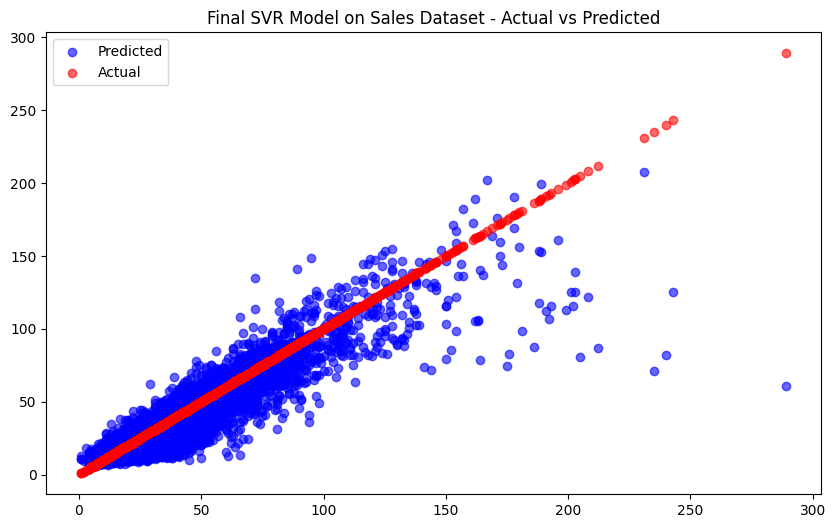

In [ ]:
# Scatter plot of Actual vs Predicted
plt.figure(figsize=(10, 6))

plt.scatter(y_test_actual, y_pred_svm, alpha=0.6, color='b', label='Predicted')
plt.scatter(y_test_actual, y_test_actual, alpha=0.6, color='r', label='Actual')

# Plot the line y = x for reference
#plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'k--', lw=2)

plt.title('Final SVR Model on Sales Dataset - Actual vs Predicted')
plt.legend()
plt.show()


In [ ]:
best_hps.values

{'num_layers': 2,
 'units_0': 512,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.0001,
 'units_1': 32}

In [ ]:
best_hps.values = {'num_layers': 1,
 'units_0': 320,
 'dropout': 0.1,
 'learning_rate': 0.001,
 'units_1': 352,
 'units_2': 288}

In [ ]:
# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitors the validation loss
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores the weights of the best model during training
)

def build_ann_model(hp):
    model = keras.models.Sequential()

    # Input layer
    model.add(keras.layers.Dense(units=hp['units_0'], activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(keras.layers.Dropout(hp['dropout']))

    # Hidden layers
    for i in range(1, hp['num_layers']):
        units = hp[f'units_{i}']
        model.add(keras.layers.Dense(units=units, activation='relu'))
        model.add(keras.layers.Dropout(hp['dropout']))

    # Output layer
    model.add(keras.layers.Dense(1, activation='linear'))  # For regression tasks

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp['learning_rate']),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])

    return model

ann_model = build_ann_model(best_hps)

ann_model.fit(X_train_scaled, y_train_log, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/100
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.5471 - mean_squared_error: 0.5471 - val_loss: 0.0793 - val_mean_squared_error: 0.0793
Epoch 2/100
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0936 - mean_squared_error: 0.0936 - val_loss: 0.0753 - val_mean_squared_error: 0.0753
Epoch 3/100
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0809 - mean_squared_error: 0.0809 - val_loss: 0.0628 - val_mean_squared_error: 0.0628
Epoch 4/100
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0751 - mean_squared_error: 0.0751 - val_loss: 0.0637 - val_mean_squared_error: 0.0637
Epoch 5/100
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0640 - val_mean_squared_error: 0.0640
Epoch 6/100
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0675 - mean_squared_error: 0.0675 - val_loss: 0.0651 - val_mean_squared_error: 0.0651
Epoch 7/100
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0681 - mean_squared_error: 0.

In [ ]:
# Predict on the test set
y_pred_log_ann = ann_model.predict(X_test_scaled).flatten()
y_pred_ann = np.expm1(y_pred_log_ann)  # Reverse the log transformation

mae_ann = mean_absolute_error(y_test_actual, y_pred_ann)
mse_ann = mean_squared_error(y_test_actual, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
r2_ann = r2_score(y_test_actual, y_pred_ann)
mape_ann = np.mean(np.abs((y_test_actual - y_pred_ann) / y_test_actual)) * 100

print("ANN Performance Metrics:")
print("MSE:", mse_ann)
print("RMSE:", rmse_ann)
print("MAE:", mae_ann)
print("R-squared:", r2_ann)
print("MAPE:", mape_ann)

1002/1002 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
ANN Performance Metrics:
MSE: 41.477383612847795
RMSE: 6.440293752061919
MAE: 3.9409554853544937
R-squared: 0.8603488044965293
MAPE: 17.436260536934107


In [ ]:
# Evaluate the model on the test set
test_loss, test_mse = ann_model.evaluate(X_test_scaled, y_test_log, verbose=0)
print(f"Test MSE: {test_mse}")

Test MSE: 0.05488041788339615


Why mse is so high and different from .evaluate()?
- The RMSE calculated on the log-transformed scale measures the average squared difference between the log-transformed predictions and the log-transformed actual values. It reflects errors in terms of the log-transformed units, not the original units.
- The RMSE value on the log scale will typically be much smaller because the log transformation reduces the magnitude of large numbers, thereby compressing the errors.

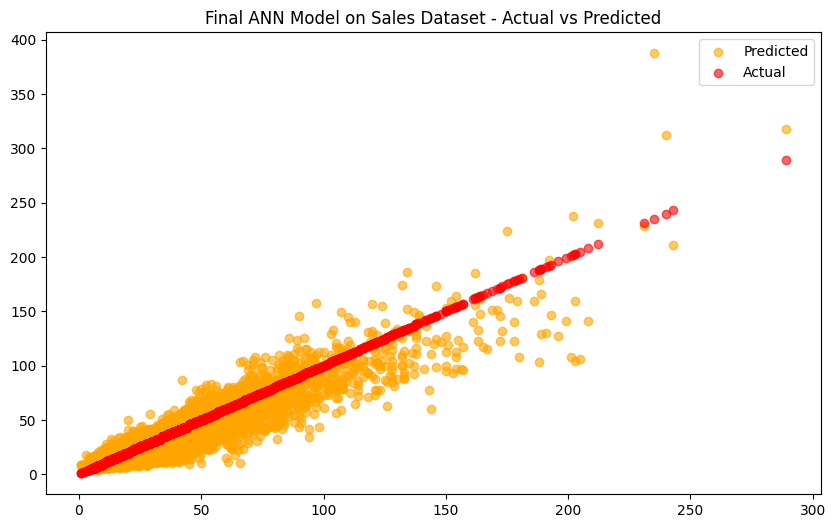

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test_actual, y_pred_ann, alpha=0.6, color='orange', label='Predicted')
plt.scatter(y_test_actual, y_test_actual, alpha=0.6, color='r', label='Actual')

# Plot the line y = x for reference
#plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'k--', lw=2)

plt.title('Final ANN Model on Sales Dataset - Actual vs Predicted')
plt.legend()
plt.show()

**Model Comparison**

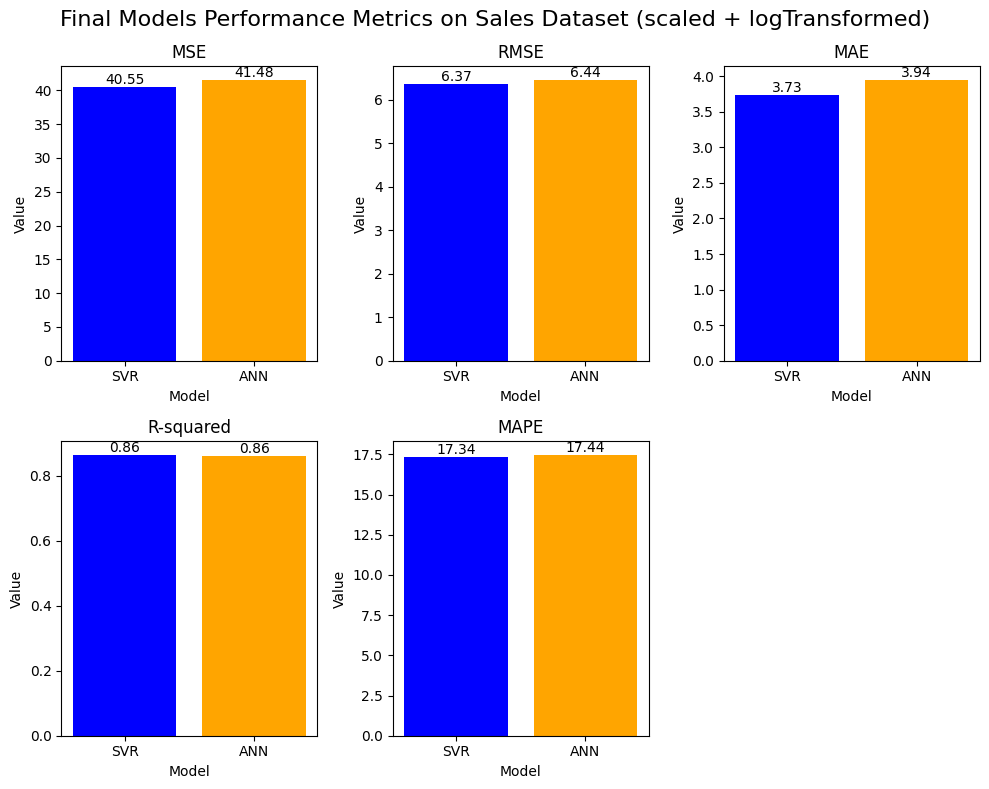

In [ ]:
metrics = ['MSE', 'RMSE', 'MAE', 'R-squared', 'MAPE']
svr_metrics = [mse_svr, rmse_svr, mae_svr, r2_svr, mape_svr]
ann_metrics = [mse_ann, rmse_ann, mae_ann, r2_ann, mape_ann]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))

axes = axes.flatten()

# Plotting each metric in its own subplot
for i, (metric, svr_metric, ann_metric) in enumerate(zip(metrics, svr_metrics, ann_metrics)):
    if svr_metric is None or ann_metric is None:
        axes[i].axis('off')  # Turn off the axis if there's no data
        continue

    ax = axes[i]
    ax.bar(['SVR', 'ANN'], [svr_metric, ann_metric], color=['blue', 'orange'])
    ax.set_title(metric)
    ax.set_xlabel('Model')
    ax.set_ylabel('Value')

    # Adding value labels on top of the bars
    for j, value in enumerate([svr_metric, ann_metric]):
        ax.text(j, value, f'{value:.2f}' if value != 0 else f'{value:.2e}', ha='center', va='bottom')

# Hide any unused subplots if the number of metrics is less than the number of axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Final Models Performance Metrics on Sales Dataset (scaled + logTransformed)', fontsize=16)

plt.tight_layout()
plt.show()

# Time Series

### Data Exploration

In [ ]:
# using restock df for this
restocks.head()

,external_code,retail,week,year,qty
0,3642,30,50,2018,5
1,3642,30,51,2018,6
2,3642,30,1,2019,2
3,3642,30,2,2019,3
4,3642,30,4,2019,4


In [ ]:
restocks['week'].unique()

array([50, 51,  1,  2,  4, 30,  9,  3, 10, 44, 22, 25, 26, 27, 29, 24, 23,
       47, 33, 31, 34, 38, 39, 40, 41, 28, 14, 13, 11, 16, 36,  6,  5, 42,
       49, 43, 48, 46,  7, 52, 45, 37,  8, 12, 15, 32, 17, 35, 19, 20, 18,
       21, 53])

In [ ]:
restocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949766 entries, 0 to 949765
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   external_code  949766 non-null  int64
 1   retail         949766 non-null  int64
 2   week           949766 non-null  int64
 3   year           949766 non-null  int64
 4   qty            949766 non-null  int64
dtypes: int64(5)
memory usage: 36.2 MB


In [ ]:
# Group by year and count unique weeks - weeks per year
weeks_per_year = restocks.groupby(restocks['year'])['week'].nunique()

print(weeks_per_year)

year
2016     5
2017    52
2018    52
2019    52
2020    23
2021    31
2022     1
Name: week, dtype: int64


2022 has only one week, we can drop, same as 2016. 2020 and 2021 have missing data (covid) so we need to use filling technique for the time series

In [ ]:
restocks_cleaned = restocks[~restocks['year'].isin([2016, 2022])]

I want to forecast the `qty` for e`ach external_code`, I can have multiple time series—one for each external_code. Options:
1. Treat each external_code as an individual time series and build separate models for each. This approach is beneficial when each external_code has distinct patterns (e.g., seasonality, trends) that wouldn't generalize well across other codes (Needs LOTS OF DATA)
2. Aggregated Time Series: If there is a rationale for treating the external_codes as a collective group (e.g., to analyze overall trends across all products), I can aggregate the data across external_codes and create a single time series. This can simplify the modeling process but may lose some granularity.
> Decision Criterias:
> - If each external_code has unique patterns: It’s best to treat them as separate time series.
> - If the goal is to understand overall trends or simplify the model: Aggregate the data across external_codes.

Action Plan:
- I will first aggregate data across external_codes

In [ ]:
restocks_cleaned['year_week'] = restocks_cleaned['year'].astype(str) + '-' + restocks_cleaned['week'].astype(str).str.zfill(2)

# Convert 'year_week' to datetime (assuming week starts on Monday)
restocks_cleaned['year_week'] = pd.to_datetime(restocks_cleaned['year_week'] + '-1', format='%Y-%W-%w')

# Set 'year_week' as the index
restocks_cleaned.set_index('year_week', inplace=True)

In [ ]:
restocks_cleaned = restocks_cleaned.drop(columns=['year','week'])

In [ ]:
restocks_cleaned = restocks_cleaned.drop(columns=['retail'])

In [ ]:
restocks_cleaned.head()

,external_code,qty
year_week,,
2018-12-10,3642,5
2018-12-17,3642,6
2019-01-07,3642,2
2019-01-14,3642,3
2019-01-28,3642,4


#### Aggregated time series

In [ ]:
aggregated_series = restocks_cleaned.groupby('year_week')['qty'].sum()

In [ ]:
# Create a complete weekly time index
complete_weeks = pd.date_range(start=aggregated_series.index.min(),
                               end=aggregated_series.index.max(), freq='W-MON')

# Reindex to include all weeks, filling missing weeks with NaN
aggregated_series = aggregated_series.reindex(complete_weeks, fill_value=np.nan)

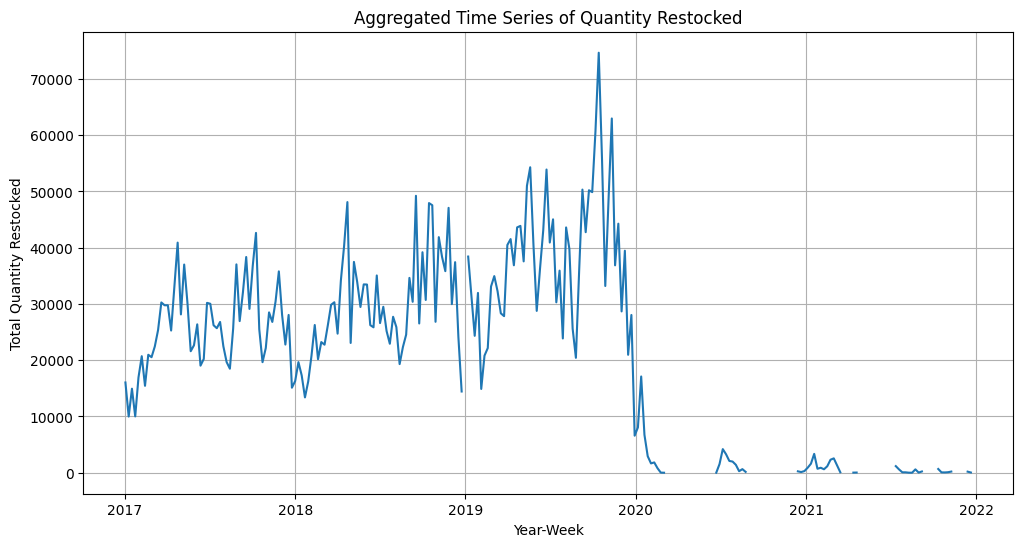

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(aggregated_series.index, aggregated_series)
plt.title('Aggregated Time Series of Quantity Restocked')
plt.xlabel('Year-Week')
plt.ylabel('Total Quantity Restocked')
plt.grid(True)
plt.show()

The period during COVID-19 is an outlier with patterns unlikely to repeat under normal circumstances. Including this period could distort your model's predictions, especially if the goal is to forecast in a post-COVID environment where conditions resemble those prior to 2020. The model could underestimate future demand.
> Question: shall I just not consider 2020 and 2021? My goal is to understand how the business might perform in a normal environment, it might be best to exclude these years...

### **1. Removing 2020 and 2021**

In [ ]:
# Drop years 2020 and 2021 due to COVID-19 anomalies
restocks_no_covid = aggregated_series[~aggregated_series.index.year.isin([2020, 2021])]

In [ ]:
restocks_no_covid.index = pd.to_datetime(restocks_no_covid.index)

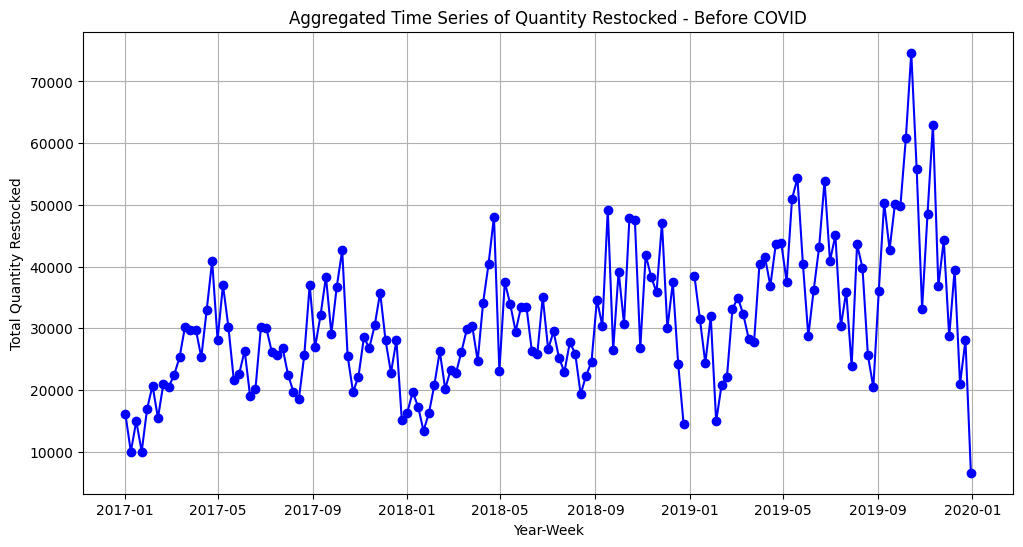

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(restocks_no_covid.index, restocks_no_covid, color='blue', linestyle='-', marker='o')
plt.title('Aggregated Time Series of Quantity Restocked - Before COVID')
plt.xlabel('Year-Week')
plt.ylabel('Total Quantity Restocked')
plt.grid(True)
plt.show()

In [ ]:
# missing values?
restocks_no_covid.isna().sum()

1

In [ ]:
# choosing backward fill as it's the last week of the year, so the next value is a good indicator
restocks_no_covid.fillna(method='bfill', inplace=True)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

def decompose(df):
    decomposition = seasonal_decompose(df, model='additive', period=7)
    # Multiplicative seasonality is not appropriate for zero and negative values
    # ('multiplicative' will cause ValuError)

    plt.figure(figsize=(12, 6))
    plt.subplot(4, 1, 1)
    plt.plot(df, label='Original Time Series')
    plt.legend()
    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()
    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal, label='Seasonality')
    plt.legend()
    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label='Residual (Noise)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def stationarity(df):
    # Perform Augmented Dickey-Fuller test for stationarity
    result = sm.tsa.adfuller(df)

    # Print the ADF test results
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')

    if p_value < 0.05:
        print("The time series is likely stationary (reject the null hypothesis)")
    else:
        print("The time series is likely non-stationary (fail to reject the null hypothesis)")

def autocorrelation(df): # needs stationary ts
    #plt.figure(figsize=(6, 2))
    plot_acf(df, lags=7);
    plt.title('Autocorrelation Function (ACF) Plot')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.gcf().set_figwidth(6)
    plt.gcf().set_figheight(3)
   # plt.show();

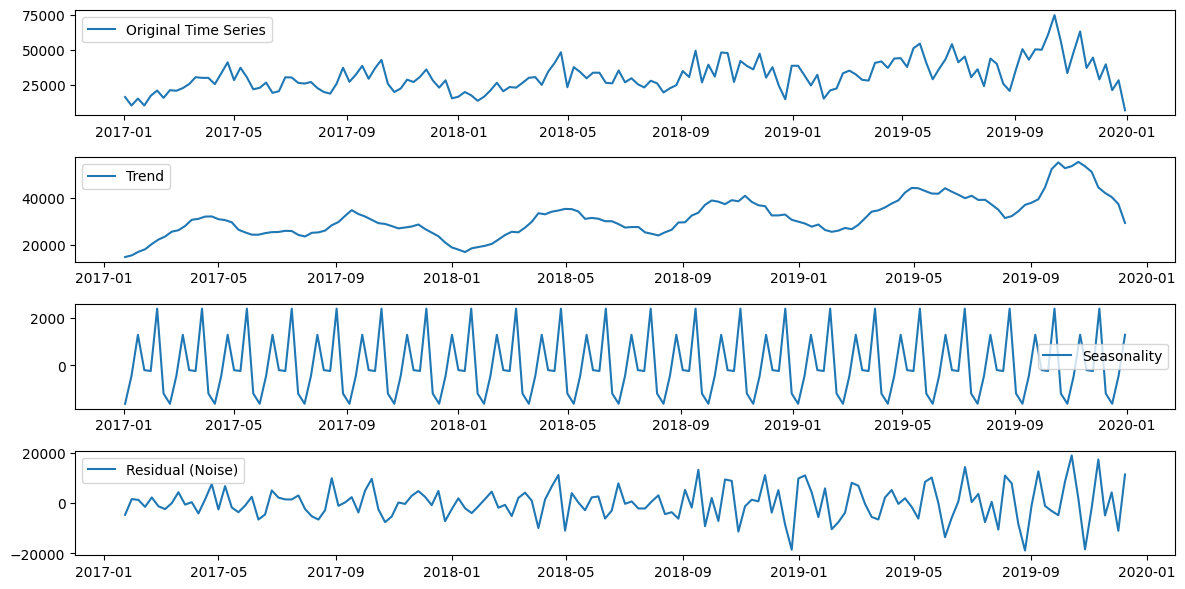

In [ ]:
decompose(restocks_no_covid)

In [ ]:
restocks_no_covid.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 157 entries, 2017-01-02 to 2019-12-30
Freq: W-MON
Series name: qty
Non-Null Count  Dtype  
--------------  -----  
157 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


In [ ]:
stationarity(restocks_no_covid)

ADF Statistic: -3.1580017674136474
p-value: 0.022548082800117015
The time series is likely stationary (reject the null hypothesis)


I will keep seasonality and trends, as they are likely to play a significant role in predicting future quantities.

>> MODELING
- Before modeling: converting the raw time series into a structured format that captures the temporal relationships (time sequence)

In [ ]:
# Export metrics_df to CSV
restocks_no_covid.to_csv('/content/drive/MyDrive/Visuelle/restocks_no_covid.csv', index=True)

In [ ]:
#!pip install scikit-learn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
restocks_no_covid.head()

,qty
2017-01-02,16043.0
2017-01-09,9985.0
2017-01-16,14938.0
2017-01-23,10011.0
2017-01-30,16936.0


In [ ]:
## TRANSFORMING INTO A TIME SEQUENCE ##
# Convert Series to DataFrame
restocks_no_covid_df = restocks_no_covid.to_frame()

# Creating lag features for 'qty'
for lag in [1, 3, 5]:
    restocks_no_covid_df[f'qty_lag_{lag}'] = restocks_no_covid_df['qty'].shift(lag)

# Dropping rows with NaN values resulting from the lag operation
restocks_no_covid_df = restocks_no_covid_df.dropna()

restocks_no_covid_df.head()

,qty,qty_lag_1,qty_lag_3,qty_lag_5
2017-02-06,20716.0,16936.0,14938.0,16043.0
2017-02-13,15451.0,20716.0,10011.0,9985.0
2017-02-20,20970.0,15451.0,16936.0,14938.0
2017-02-27,20540.0,20970.0,20716.0,10011.0
2017-03-06,22443.0,20540.0,15451.0,16936.0


In [ ]:
restocks_no_covid_df.shape

(152, 4)

In [ ]:
## Preparing data for modeling ##
X = restocks_no_covid_df[['qty_lag_1', 'qty_lag_3', 'qty_lag_5']]
y = restocks_no_covid_df['qty']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((121, 3), (31, 3), (121,), (31,))

In [ ]:
# Fit, evaluate, and return RMSE for a model and DataFrame
def fit_evaluate_model(model, df):

    model_instance = model(y_train)
    model_fit = model_instance.fit()

    # Forecasting based on training data length and test set size
    predictions = model_fit.forecast(steps=len(y_test))

    rmse_value = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse_value

In [ ]:
def sarima_model(x):
    return SARIMAX(x, order=(1, 1, 1))

def arima_model(x):
    return ARIMA(x, order=(0, 1, 1))

def exp_smoothing_model(x):
    return ExponentialSmoothing(x, seasonal='add', seasonal_periods=7)


models = [sarima_model, arima_model, exp_smoothing_model]

In [ ]:
def compare_models(df, models):
    results = []
    for model in models:
        model_name = model.__name__
        rmse = fit_evaluate_model(model, df)
        results.append(rmse)

    df_results = pd.DataFrame(results, columns=['RMSE'])
    df_results.index = [model.__name__ for model in models]

    return df_results

In [ ]:
results = compare_models(restocks_no_covid, models)
results.head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,RMSE
sarima_model,14853.304335
arima_model,14873.271236
exp_smoothing_model,14976.368702


> Model chosen: SARIMA
>> Justification: SARIMA accounts for seasonality, so it may be preferable as seasonality is important in this dataset

In [ ]:
(restocks_cleaned.shape, aggregated_series.shape)

((945271, 2), (260,))

Let's re-do using the full data, not aggregated

In [ ]:
data = restocks[~restocks['year'].isin([2016, 2020, 2021, 2022])]
data.shape

(924549, 5)

In [ ]:
data['year_week'] = data['year'].astype(str) + '-' + data['week'].astype(str).str.zfill(2)

data['year_week'] = pd.to_datetime(data['year_week'] + '-1', format='%Y-%W-%w')
data.set_index('year_week', inplace=True)

In [ ]:
# Ensure the data is sorted by the datetime index
data = data.sort_index()

In [ ]:
## TRANSFORMING INTO A TIME SEQUENCE ##
# Convert Series to DataFrame
for lag in [1, 3, 5]:
    data[f'qty_lag_{lag}'] = data['qty'].shift(lag)

data = data.dropna()

## Preparing data for modeling ##
X = data[['qty_lag_1', 'qty_lag_3', 'qty_lag_5']]
y = data['qty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((739635, 3), (184909, 3), (739635,), (184909,))

In [ ]:
data.head()

,external_code,retail,week,year,qty,qty_lag_1,qty_lag_3,qty_lag_5
year_week,,,,,,,,
2017-01-02,77,8,1,2017,8,5.0,8.0,5.0
2017-01-02,104,13,1,2017,11,8.0,11.0,6.0
2017-01-02,52,66,1,2017,1,11.0,5.0,8.0
2017-01-02,104,16,1,2017,6,1.0,8.0,11.0
2017-01-02,77,41,1,2017,5,6.0,11.0,5.0


In [ ]:
results2 = compare_models(data, models)
results2.head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p

,RMSE
sarima_model,3.972283
arima_model,3.986276
exp_smoothing_model,3.924510


**Hyperparameters tuning**

In [ ]:
from sklearn.model_selection import train_test_split

def evaluate_sarima(order, data):
    p, d, q = order
    try:

        # Fit the SARIMA model on the training data
        model = SARIMAX(y_train, order=(p, d, q))
        results = model.fit(disp=False)

        # Forecasting based on training data length and test set size
        forecast = results.forecast(steps=len(y_test))

        # Calculate RMSE (Root Mean Squared Error) for model evaluation
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        return rmse

    except Exception as e:
        print(f"An error occurred: {e}")
        return float('inf')

p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Initialize variables to store best hyperparameters and RMSE
best_rmse = float('inf')
best_order = (0, 0, 0)

In [ ]:
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            rmse = evaluate_sarima(order, data)
            #print(f'P={p} - D={d} - Q={q} : RMSE={rmse}')
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order

In [ ]:
print(f"Best SARIMA Order: {best_order}")

Best SARIMA Order: (2, 1, 1)


**Final model**

In [ ]:
# Fit the SARIMAX model with the specified order
model = SARIMAX(y_train, order=(2, 1, 1))
model_fit = model.fit(disp=False)

# Make predictions
predictions = model_fit.forecast(steps=len(y_test))

rmse_final = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Final model RMSE on test set: {rmse_final}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Final model RMSE on test set: 3.9503144466292195


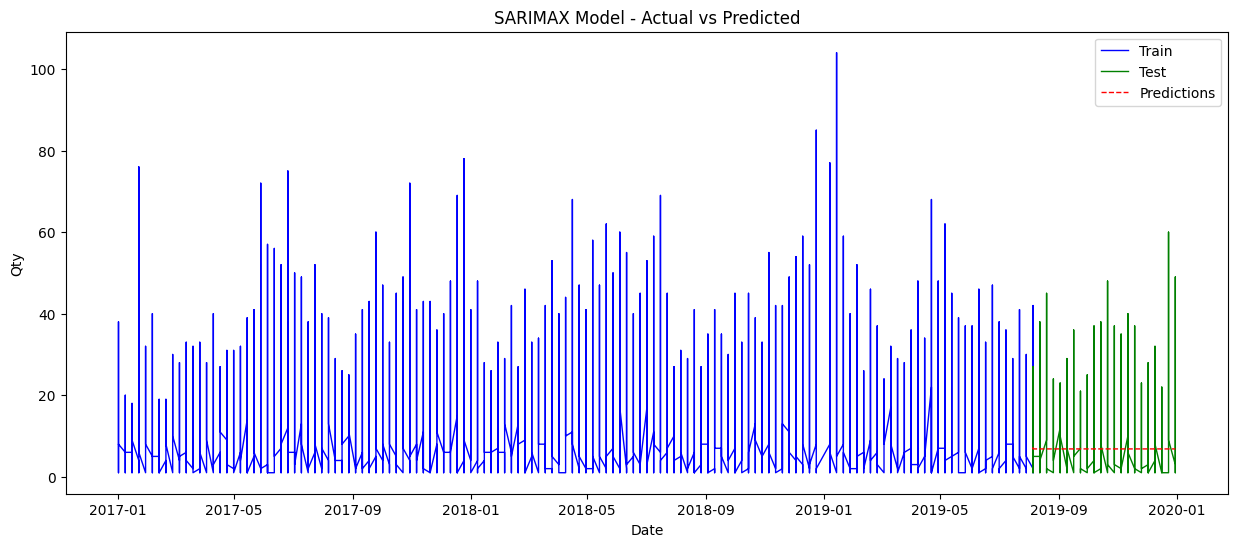

In [ ]:
# Plot the actual values and the predictions
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='Train', color='blue', linewidth=1)
plt.plot(y_test.index, y_test, label='Test', color='green', linewidth=1)
plt.plot(y_test.index, predictions, label='Predictions', color='red', linestyle='--', linewidth=1)
plt.title('SARIMAX Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.show()

###**2. Use weighting**

In [ ]:
# aggregated_series. First deal with missing data - Second: modeling

In [ ]:
aggregated_series.isna().sum()

51

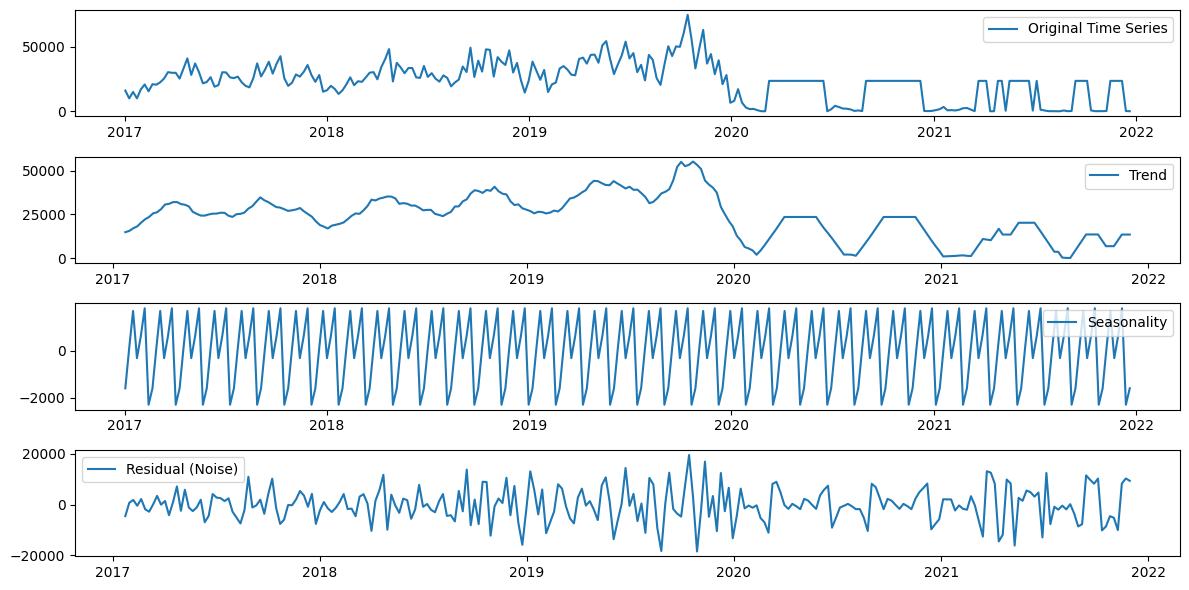

ADF Statistic: -3.4771473991056356
p-value: 0.008593763902985168
The time series is likely stationary (reject the null hypothesis)


In [ ]:
# mean imputation
df_mean = (aggregated_series.fillna(aggregated_series.mean())).to_frame()
decompose(df_mean)
stationarity(df_mean)

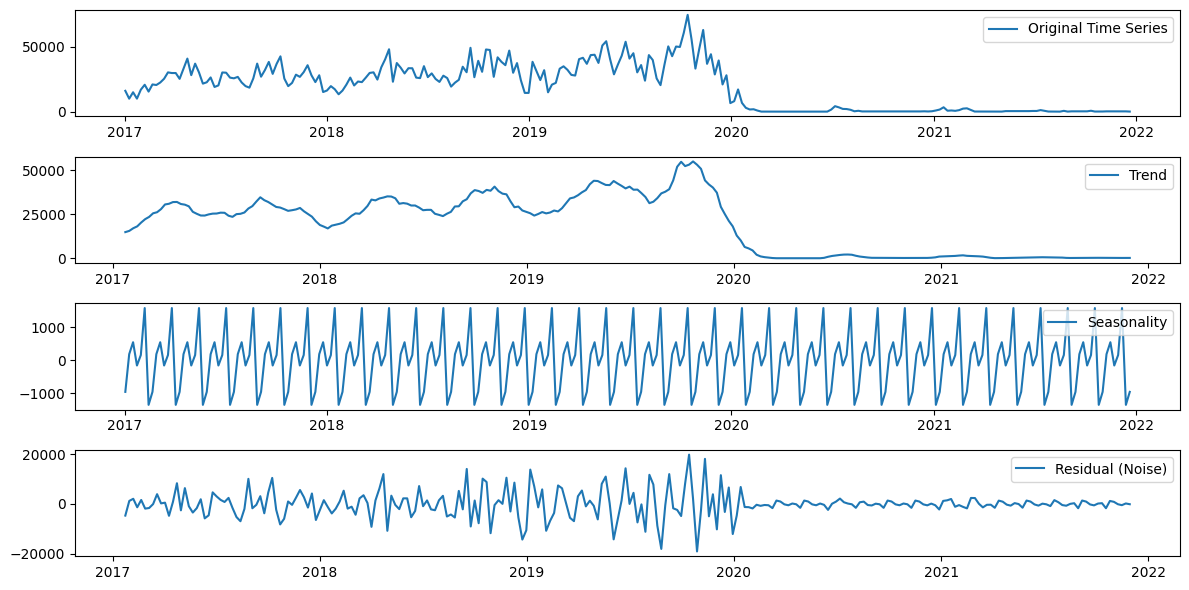

ADF Statistic: -1.497371052460252
p-value: 0.5348114384755973
The time series is likely non-stationary (fail to reject the null hypothesis)


In [ ]:
# forward fill
df_ffill = (aggregated_series.fillna(method='ffill')).to_frame()
decompose(df_ffill)
stationarity(df_ffill)

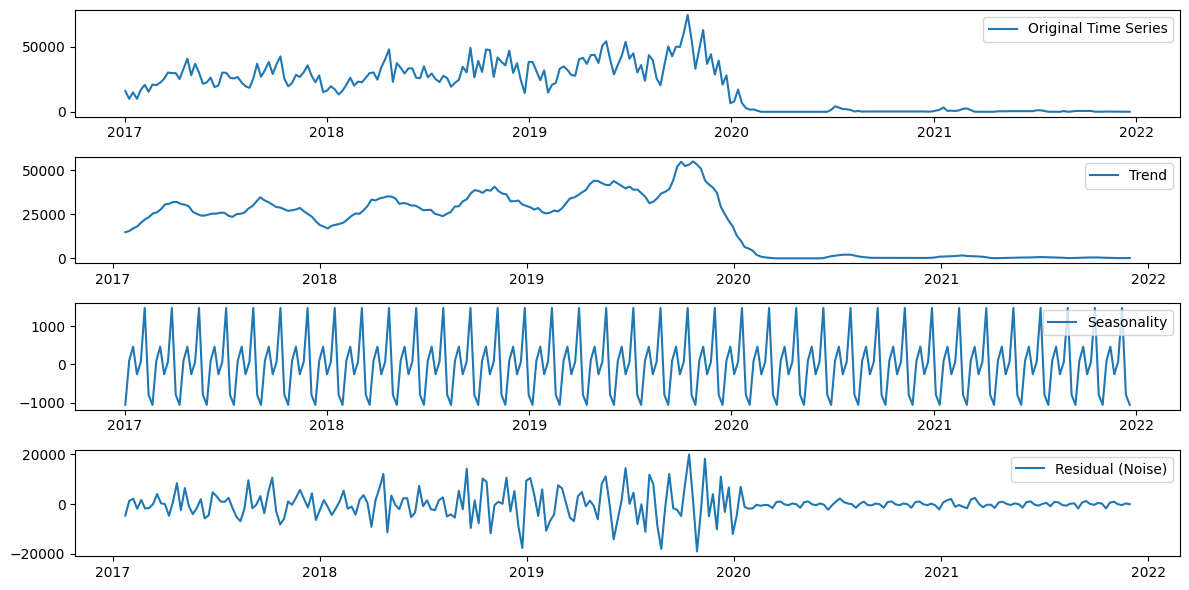

ADF Statistic: -1.4640530275048762
p-value: 0.5512129777119805
The time series is likely non-stationary (fail to reject the null hypothesis)


In [ ]:
# backward fill
df_bfill = (aggregated_series.fillna(method='bfill')).to_frame()
decompose(df_bfill)
stationarity(df_bfill)

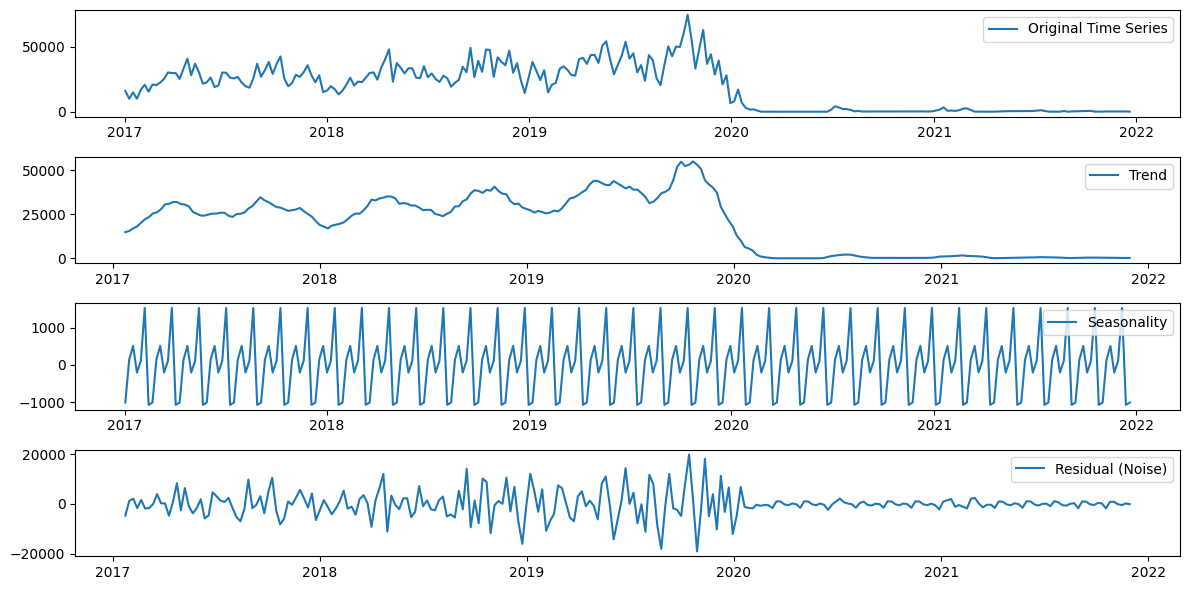

ADF Statistic: -1.4721188456266558
p-value: 0.5472559156107307
The time series is likely non-stationary (fail to reject the null hypothesis)


In [ ]:
# linear interpolation
df_int = (aggregated_series.interpolate(method='linear')).to_frame()
decompose(df_int)
stationarity(df_int)

In [ ]:
# adding median and cubic to have the full picture
df_median = (aggregated_series.fillna(aggregated_series.median())).to_frame()
df_cub = (aggregated_series.interpolate(method='cubic')).to_frame()

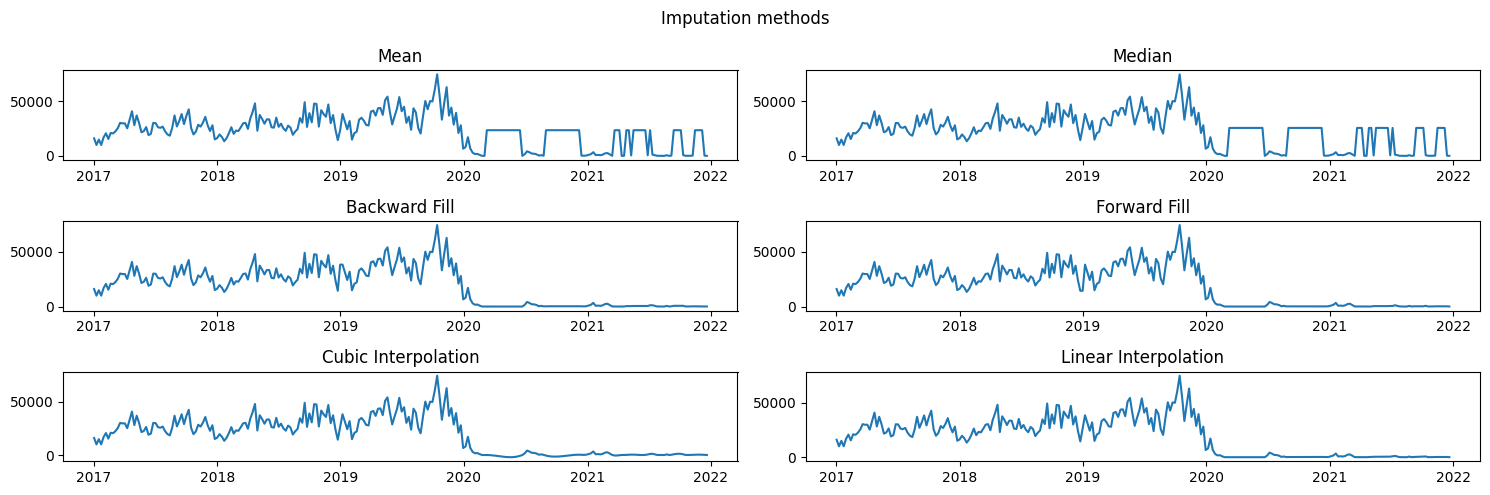

In [ ]:
# summary
fig, axes = plt.subplots(3, 2, figsize=(15, 5))

axes[0, 0].plot(df_mean)
axes[0, 0].set_title('Mean')
axes[0, 1].plot(df_median)
axes[0, 1].set_title('Median')
axes[1, 1].plot(df_ffill)
axes[1, 1].set_title('Forward Fill')
axes[1, 0].plot(df_bfill)
axes[1, 0].set_title('Backward Fill')
axes[2, 1].plot(df_int)
axes[2, 1].set_title('Linear Interpolation')
axes[2, 0].plot(df_cub)
axes[2, 0].set_title('Cubic Interpolation')

fig.suptitle('Imputation methods')
plt.tight_layout()
plt.show()

In [ ]:
def compare_models_on_datasets(dfs, models):
    results = []
    for model in models:
        model_name = model.__name__
        model_results = []
        for df in dfs:
            rmse = fit_evaluate_model(model, df)
            model_results.append(rmse)
        results.append(model_results)

    # Create a DataFrame to display the results
    df_results = pd.DataFrame(results, columns=[f'DF{i+1}' for i in range(len(dfs))])
    df_results.index = [model.__name__ for model in models]

    return df_results

dfs = [df_bfill, df_ffill, df_int, df_cub]

In [ ]:
comp = compare_models_on_datasets(dfs, models)

In [ ]:
comp.head()

,DF1,DF2,DF3,DF4
sarima_model,765.338526,748.437290,748.753601,798.959712
arima_model,765.923411,747.856817,749.103208,795.793061
exp_smoothing_model,1243.198501,1307.458503,1265.153727,1283.552698


In [ ]:
# model sarima - df: df_ffill

Most common statistical libraries (like statsmodels in Python) do not directly support weighted fitting for SARIMA, we need to use a different one

**Modelling** - apply weights

In [ ]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 51.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [ ]:
from pygam import LinearGAM
import xgboost as xgb
from lightgbm import LGBMRegressor

In [ ]:
## TRANSFORMING INTO A TIME SEQUENCE ##
# Convert Series to DataFrame
for lag in [1, 3, 5]:
    df_ffill[f'qty_lag_{lag}'] = df_ffill['qty'].shift(lag)

df_ffill = df_ffill.dropna()

## Preparing data for modeling ##
X = df_ffill[['qty_lag_1', 'qty_lag_3', 'qty_lag_5']]
y = df_ffill['qty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((127, 3), (128, 3), (127,), (128,))

In [ ]:
# Apply Weighting
weights = np.ones(len(df_ffill))

# Assign lower weights to 2020 and 2021
covid_period = (df_ffill.index.year >= 2020) & (df_ffill.index.year <= 2021)
weights[covid_period] = 0.00001

In [ ]:
# Adjust weights to match the training set size
train_weights = weights[:len(X_train)]

In [ ]:
results = {}

In [ ]:
# 1. Generalized Additive Model (GAM)
gam = LinearGAM().gridsearch(X_train.values, y_train.values, weights=train_weights)

gam_pred = gam.predict(X_test.values)
results['GAM'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, gam_pred)),
    'MAE': mean_absolute_error(y_test, gam_pred),
    'R2': r2_score(y_test, gam_pred)
}

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [ ]:
# 2. XGBoost with sample weights
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgboost_model.fit(X_train, y_train, sample_weight=train_weights)

xgboost_pred = xgboost_model.predict(X_test)
results['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, xgboost_pred)),
    'MAE': mean_absolute_error(y_test, xgboost_pred),
    'R2': r2_score(y_test, xgboost_pred)
}

In [ ]:
# 3. LightGBM with sample weights
lgbm_model = LGBMRegressor(n_estimators=100)
lgbm_model.fit(X_train, y_train, sample_weight=train_weights)

lgbm_pred = lgbm_model.predict(X_test)
results['LightGBM'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, lgbm_pred)),
    'MAE': mean_absolute_error(y_test, lgbm_pred),
    'R2': r2_score(y_test, lgbm_pred)
}

In [ ]:
results_df = pd.DataFrame(results).T
results_df.head()

,RMSE,MAE,R2
GAM,8027.977839,6869.209141,0.772622
XGBoost,16127.030082,15341.653694,0.082417
LightGBM,19551.184204,18888.035507,-0.348599


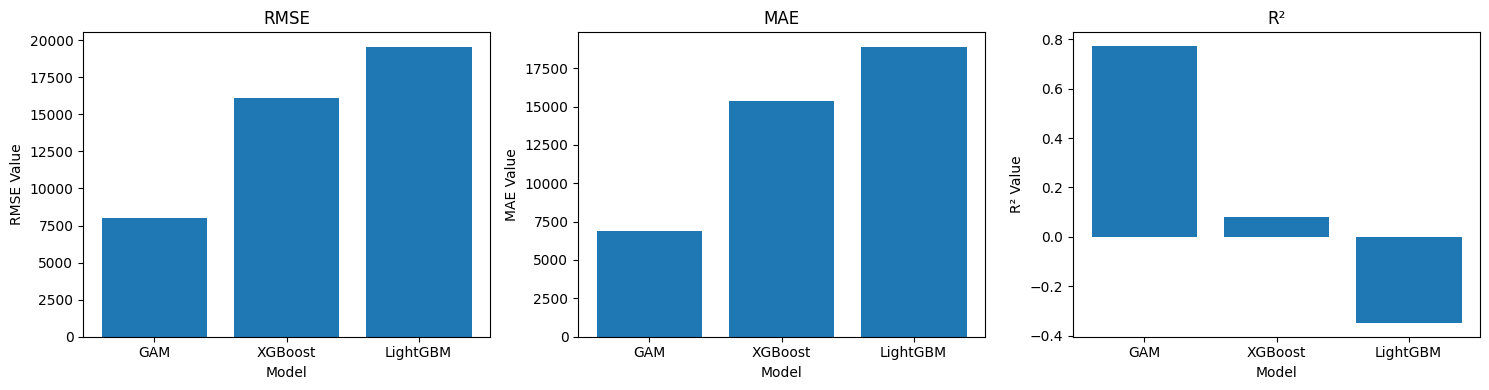

In [ ]:
results_df_transposed = results_df.T

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# RMSE Bar Plot
axes[0].bar(results_df_transposed.columns, results_df_transposed.loc['RMSE'])
axes[0].set_title('RMSE')
axes[0].set_ylabel('RMSE Value')
axes[0].set_xlabel('Model')

# MAE Bar Plot
axes[1].bar(results_df_transposed.columns, results_df_transposed.loc['MAE'])
axes[1].set_title('MAE')
axes[1].set_ylabel('MAE Value')
axes[1].set_xlabel('Model')

# R2 Bar Plot
axes[2].bar(results_df_transposed.columns, results_df_transposed.loc['R2'])
axes[2].set_title('R²')
axes[2].set_ylabel('R² Value')
axes[2].set_xlabel('Model')

plt.tight_layout()
plt.show()

In [ ]:
# GAM is the best
from pygam import LinearGAM, s, f

In [ ]:
# Define hyperparameter grid for tuning
lam_values = np.logspace(-4, 4, 10)  # Range of smoothing parameters
n_splines_values = [5, 10, 20]       # Different numbers of splines

# Perform grid search
gam = LinearGAM(s(0) + s(1) + s(2))
gam.gridsearch(X_train.values, y_train.values, weights=train_weights,
               lam=lam_values)

best_lam = gam.lam
print(f"Best lambda: {best_lam}")

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Best lambda: [[10000.0], [10000.0], [10000.0]]


In [ ]:
# Train the best model on the training data with the best lambda
best_gam = LinearGAM(s(0, n_splines=n_splines_values[1]) +
                     s(1, n_splines=n_splines_values[1]) +
                     s(2, n_splines=n_splines_values[1]),
                     lam=best_lam)
best_gam.fit(X_train.values, y_train.values, weights=train_weights)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + s(2) + intercept, 
   tol=0.0001, verbose=False)

In [ ]:
# Predictions and evaluation for the best GAM
gam_pred = best_gam.predict(X_test.values)
results = {
        'RMSE': np.sqrt(mean_squared_error(y_test, gam_pred)),
        'MAE': mean_absolute_error(y_test, gam_pred),
        'R2': r2_score(y_test, gam_pred)
    }

In [ ]:
results

{'RMSE': 9742.538148657108, 'MAE': 9131.442755417182, 'R2': 0.6651264997387547}

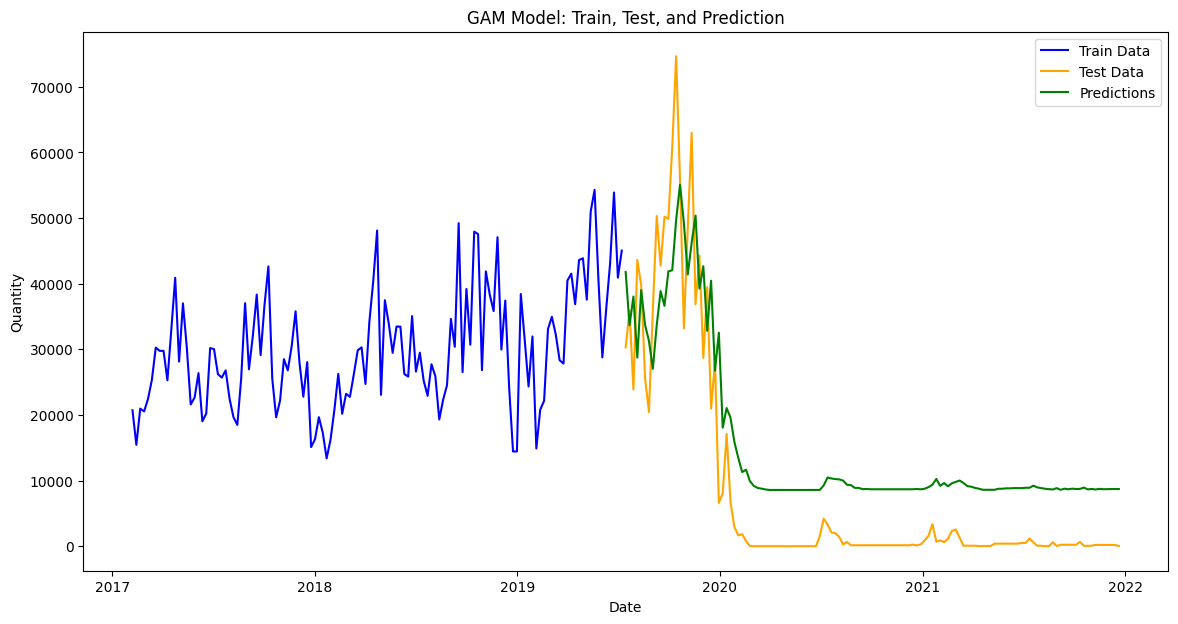

In [ ]:
# Plotting the train, test, and predictions
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(df_ffill.index[:len(X_train)], y_train, label='Train Data', color='blue')

# Plot testing data
plt.plot(df_ffill.index[len(X_train):], y_test, label='Test Data', color='orange')

# Plot predictions
plt.plot(df_ffill.index[len(X_train):], gam_pred, label='Predictions', color='green')

plt.title('GAM Model: Train, Test, and Prediction')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

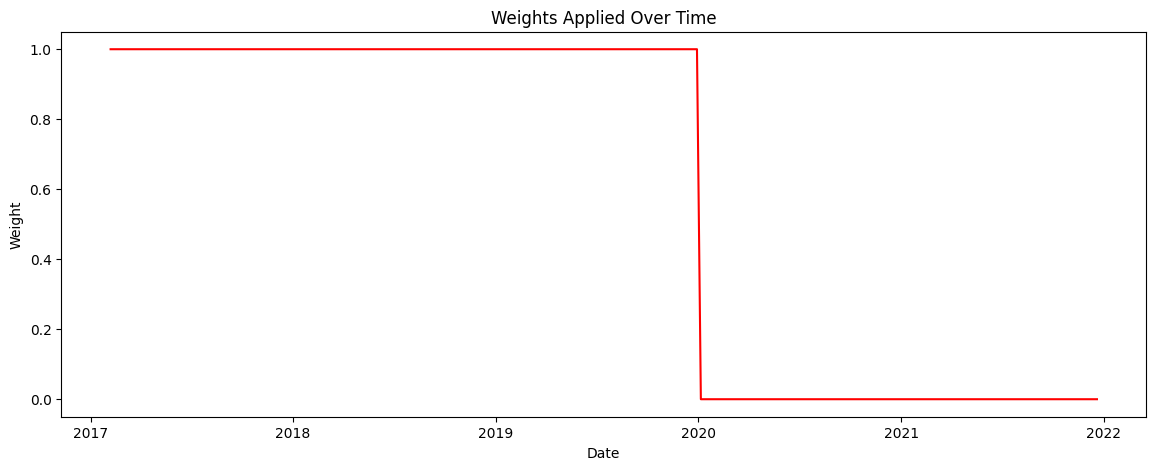

In [ ]:
# Plot the weights to see their distribution over time
plt.figure(figsize=(14, 5))
plt.plot(df_ffill.index, weights, label='Weights', color='red')
plt.title('Weights Applied Over Time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.show()